# Drought Analysis at the Regional Scale

This code was created to calculate the slope and perform a drought analysis on a regional scale using  wells with at least 15 years of data and without extreme values.

To run this code, you need to follow all of the DataPreprocessing instructions.

Total time to run on my machine: < 5 minutes

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
import scipy.stats as sp
import sys

# Add the path to the Utils folder
utils_path = os.path.abspath(os.path.join('..', 'Utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Now you can import the functions from CustomFunctions.py
import CustomFunctions as cf

# Local paths
inputpath = '../../Data/Input'
outputpath = '../../Data/Output/Local'
shapepath = inputpath+'/Shapefiles'
figurepath = '../../Figures/Local'

In [2]:
# %%  ==== Reading in the data ====
filename_georeg = 'georeg_reproject_fixed.shp'
filepath = os.path.join(shapepath, filename_georeg)
georeg = gp.read_file(filepath)
# georeg.plot(cmap='viridis')

georeg['GEOREGI_NU'] = georeg['GEOREGI_NU'].astype('int64')
print("Shapefile Loaded.")
georeg.info()
print("")

# For regulation
filepath = f'{outputpath}/Waterlevels_Regulation_updated_thresh15outliersdeleted.csv'
cat_wl2_reg = pd.read_csv(filepath, index_col=0)
print("Water Levels for Groundwater Regulation Analysis loaded.")

# For Access to SW
filepath = f'{outputpath}/Waterlevels_AccesstoSW_updated_thresh15outliersdeleted.csv'
cat_wl2_SW = pd.read_csv(filepath, index_col=0)
print("Water Levels for Access to Surface Water Analysis loaded.")

# Read in the drought indices
#  Input the date you downloaded the drought files
date_downloaded = "06102024"

drought_indices = pd.read_csv(f'{inputpath}/Yearly_DroughtIndices_updated{date_downloaded}.csv')
drought_indices = drought_indices.set_index('In_year')
print("Drought data loaded and formatted.")

Shapefile Loaded.
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   GEO_Region  11 non-null     object  
 1   GEOREGI_NU  11 non-null     int64   
 2   Water_CAT   11 non-null     object  
 3   Loc         11 non-null     object  
 4   Regulation  11 non-null     object  
 5   geometry    11 non-null     geometry
dtypes: geometry(1), int64(1), object(4)
memory usage: 656.0+ bytes

Water Levels for Groundwater Regulation Analysis loaded.
Water Levels for Access to Surface Water Analysis loaded.
Drought data loaded and formatted.


In [3]:
# %% Creating colors
# Color blind palette
# https://jacksonlab.agronomy.wisc.edu/2016/05/23/15-level-colorblind-friendly-palette/
cblind =["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]

drought_color = "#D0CECE" #'#ffa6b8'

# Matching new map
cap = '#77A8A5' #'#C6652B'
cap_secondary = '#004D40'
# noCAP = '#EDE461' # This is one from the map
noCAP = '#CCC339' # This color but darker for lines
GWdom = '#3B76AF'
mixed = '#6EB2E4'
swdom = '#469B76'

## Analysis
Wanting to look at 
1) Maximum Drawdown compared to the trend 
2) Anomalies 
3) Recovery

Decided from the drought indices analysis that the cutoff value is -3 for severe droughts


In [4]:
# %% Drought dictionary
DROUGHT_YEARS = {
        # 1:[1989,1990]
        # ,2:[1996]
        3:[2002,2003]
        ,4:[2006,2007]
        ,5:[2012,2013,2014]
        ,6:[2018]
        ,7:[2021]}

print(DROUGHT_YEARS)

{3: [2002, 2003], 4: [2006, 2007], 5: [2012, 2013, 2014], 6: [2018], 7: [2021]}


In [5]:
#%% Pre-drought
# PREDROUGHT_YEARS = {1:[1988]
#         ,2:[1995]
#         ,3:[2001]
#         ,4:[2005]
#         ,5:[2011]
#         ,6:[2017]}

PREDROUGHT_YEARS = {1:[*range(1975,1988,1)]
        ,2:[*range(1991,1995,1)]
        ,3:[*range(1997,2001,1)]
        ,4:[*range(2004,2005,1)]
        ,5:[*range(2006,2011,1)]
        ,6:[*range(2015,2017,1)]}

print(PREDROUGHT_YEARS)

{1: [1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987], 2: [1991, 1992, 1993, 1994], 3: [1997, 1998, 1999, 2000], 4: [2004], 5: [2006, 2007, 2008, 2009, 2010], 6: [2015, 2016]}


In [6]:
#%% Print the average PDSI and PHDI values

ds = drought_indices.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


pdsi_avg = ds.groupby(['Status']).mean()
pdsi_avg

PDSI  wet  dry      PHDI
Status                                  
Drought 3  -4.109167  3.0 -3.0 -4.109167
Drought 4  -3.657917  3.0 -3.0 -3.657917
Drought 5  -3.176111  3.0 -3.0 -3.176111
Drought 6  -3.342500  3.0 -3.0 -4.258333
Drought 7  -3.826667  3.0 -3.0 -3.826667
Normal-Wet -0.158110  3.0 -3.0 -0.114065

### Regulated versus Unregulated - Step by step

In [35]:
# %% Figure out which water level database you want
cat_wl2 = cat_wl2_reg.copy() 

Min_year_of_Study = 2000
Max_year_of_Study = 2022

# Water Analysis period
wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=Max_year_of_Study)]

del wlanalysis_period['Res']
wlanalysis_period.head()

drought_indices_reg = drought_indices[(drought_indices.index>=Min_year_of_Study)&(drought_indices.index<=Max_year_of_Study)]

Results for Groundwater Regulation (2000-2022):
Kendall Correlation coefficient
 R:
  tau = -0.241
  pval = 0.1137
 U:
  tau = -0.02
  pval = 0.9168
Spearman Correlation coefficient
 R:
  rho = -0.344
  pval = 0.1081
 U:
  rho = -0.001
  pval = 0.9964
Pearson Correlation coefficient
 R:
  rsq = 0.06
  pval = 0.2596
 U:
  rsq = 0.001
  pval = 0.8937



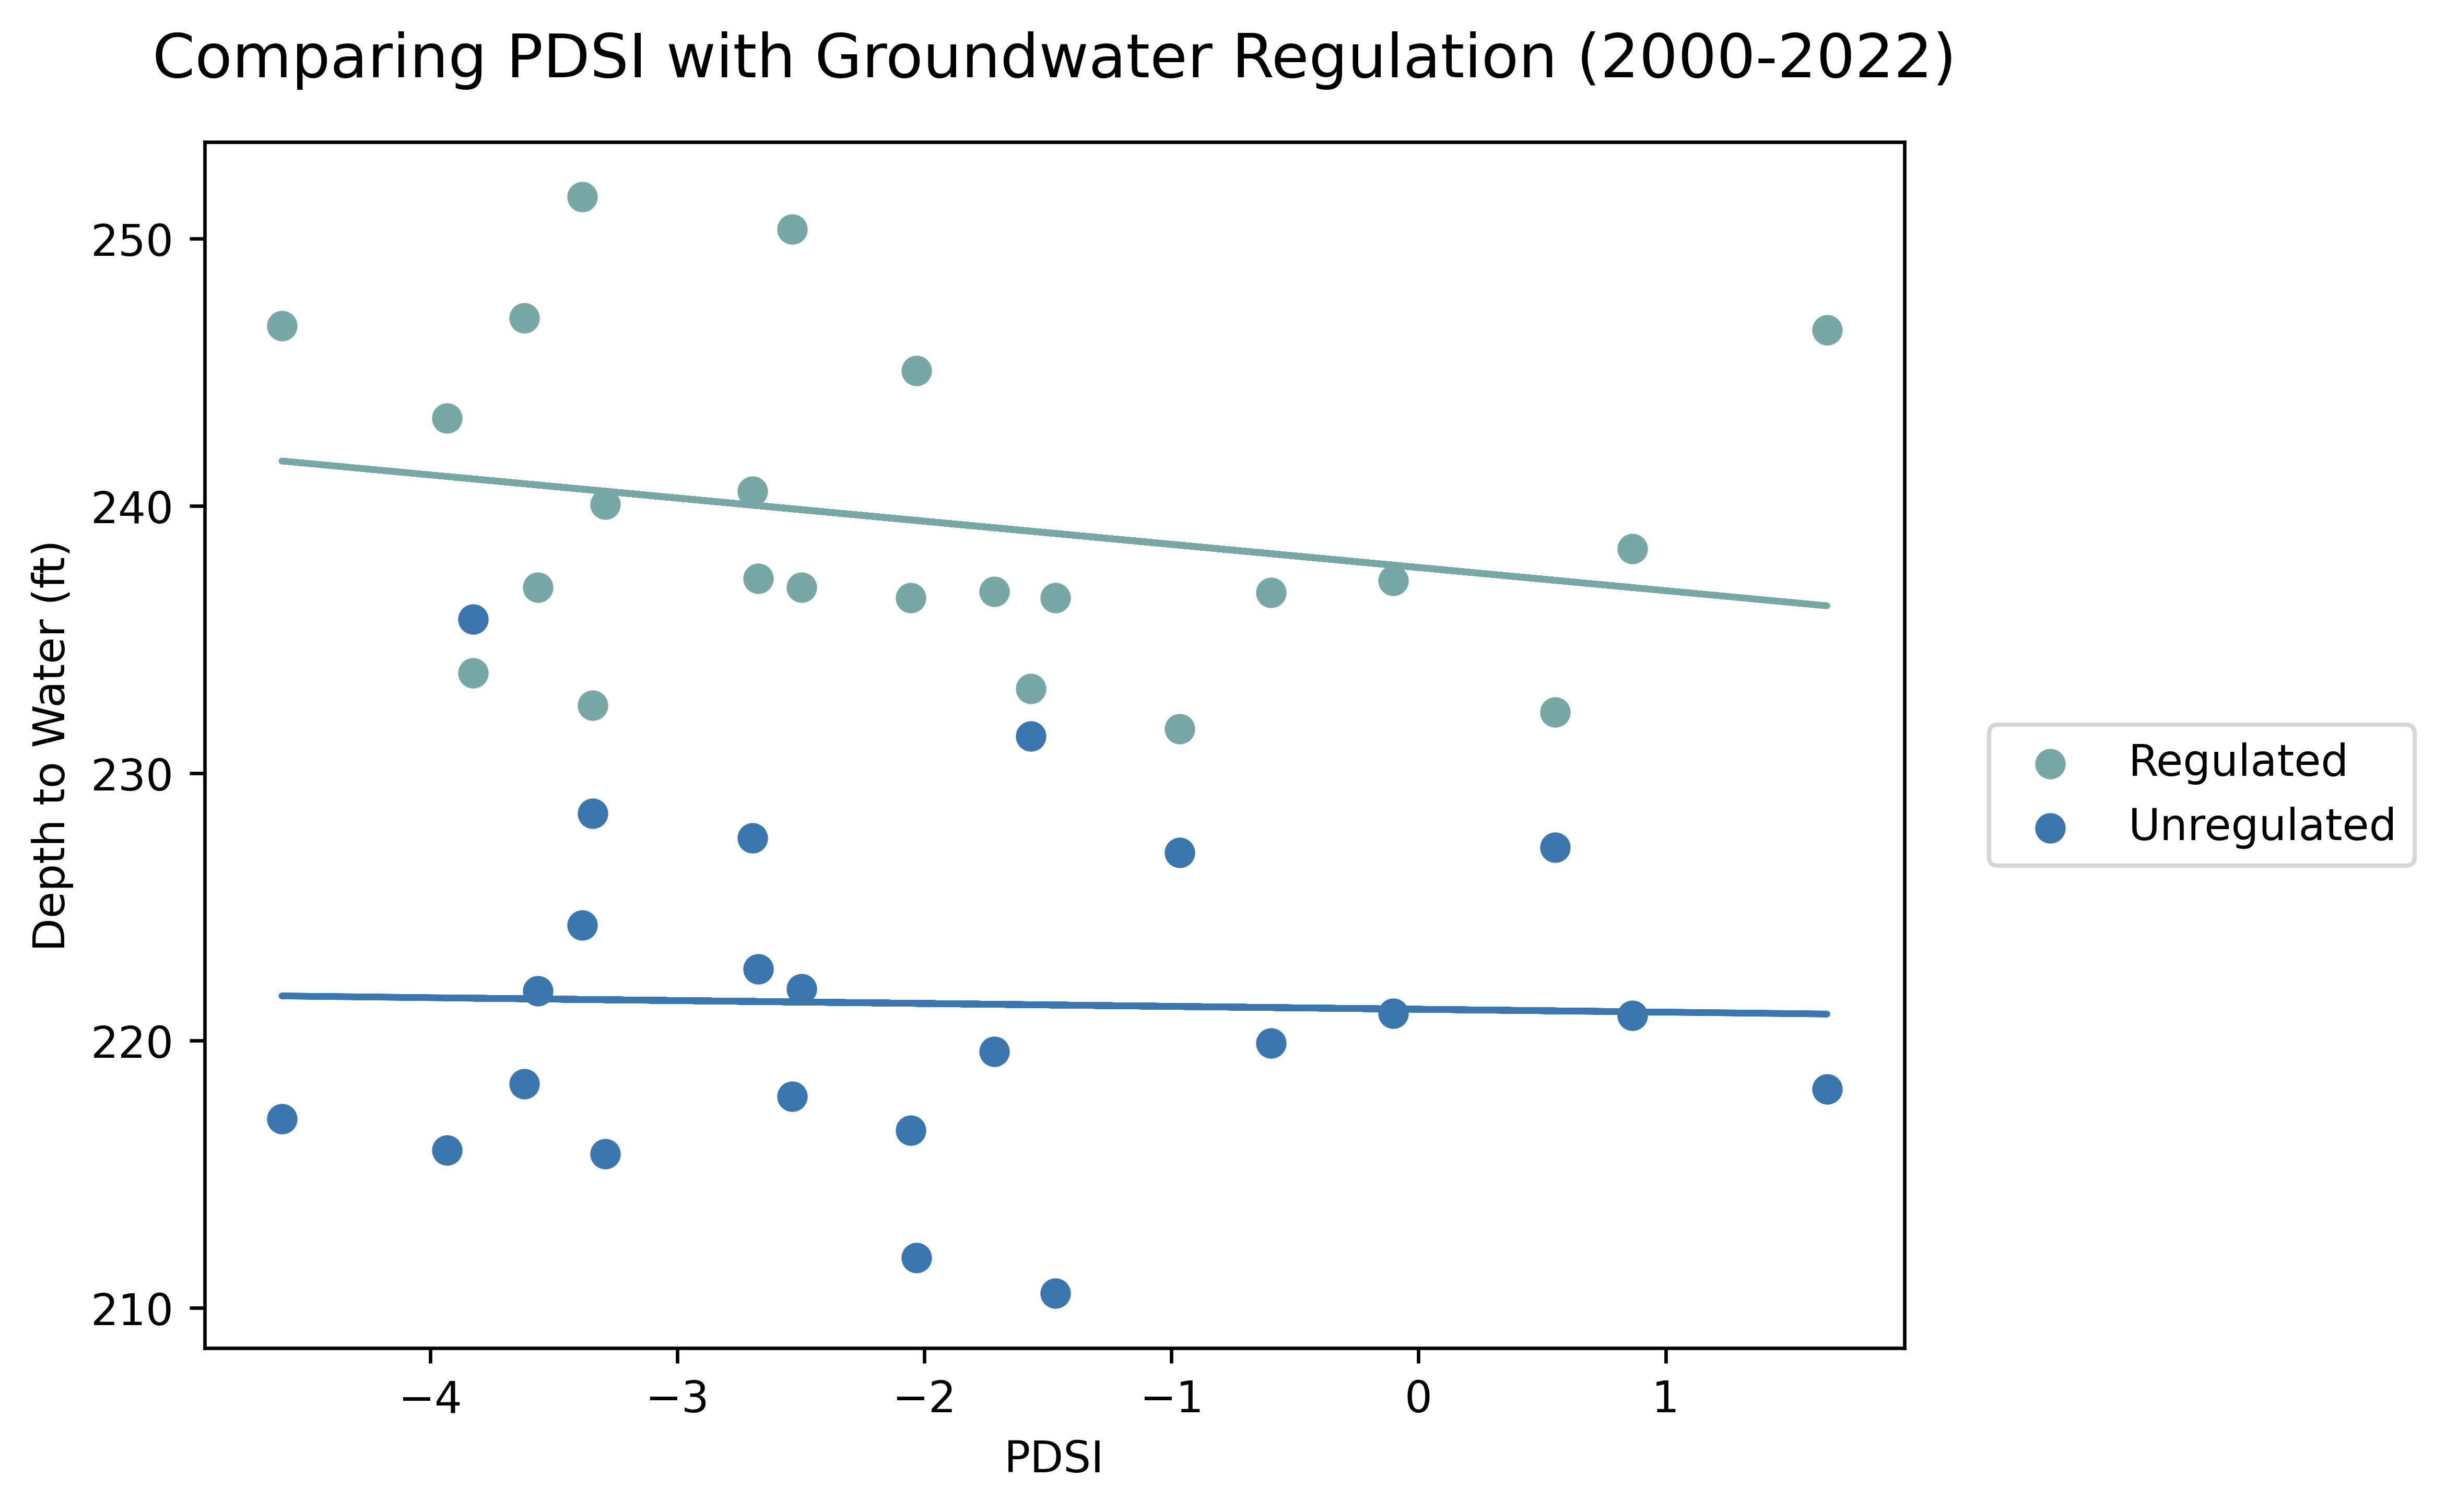

In [36]:
test_name = "Groundwater Regulation ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = wlanalysis_period
drought = drought_indices_reg
lag = 0
indice = 'PDSI'

betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
vert_axis = "Depth to Water (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,colors,betterlabels,vert_axis)
print(result)

For Calculating Anomlies

In [37]:
# Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()
trend_df = wlanalysis_period.copy()
dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]
        

dtw_anomalys.head()

R         U
index                    
2000   3.026903  2.661843
2001  -9.412975  5.215529
2002   0.839126  0.711753
2003   1.843087  1.449180
2004   0.575043 -5.597424

Results for Groundwater Regulation Anomalies (2000-2022):
Kendall Correlation coefficient
 R:
  tau = -0.202
  pval = 0.1888
 U:
  tau = -0.138
  pval = 0.3734
Spearman Correlation coefficient
 R:
  rho = -0.284
  pval = 0.1897
 U:
  rho = -0.224
  pval = 0.3035
Pearson Correlation coefficient
 R:
  rsq = 0.099
  pval = 0.1447
 U:
  rsq = 0.01
  pval = 0.6437



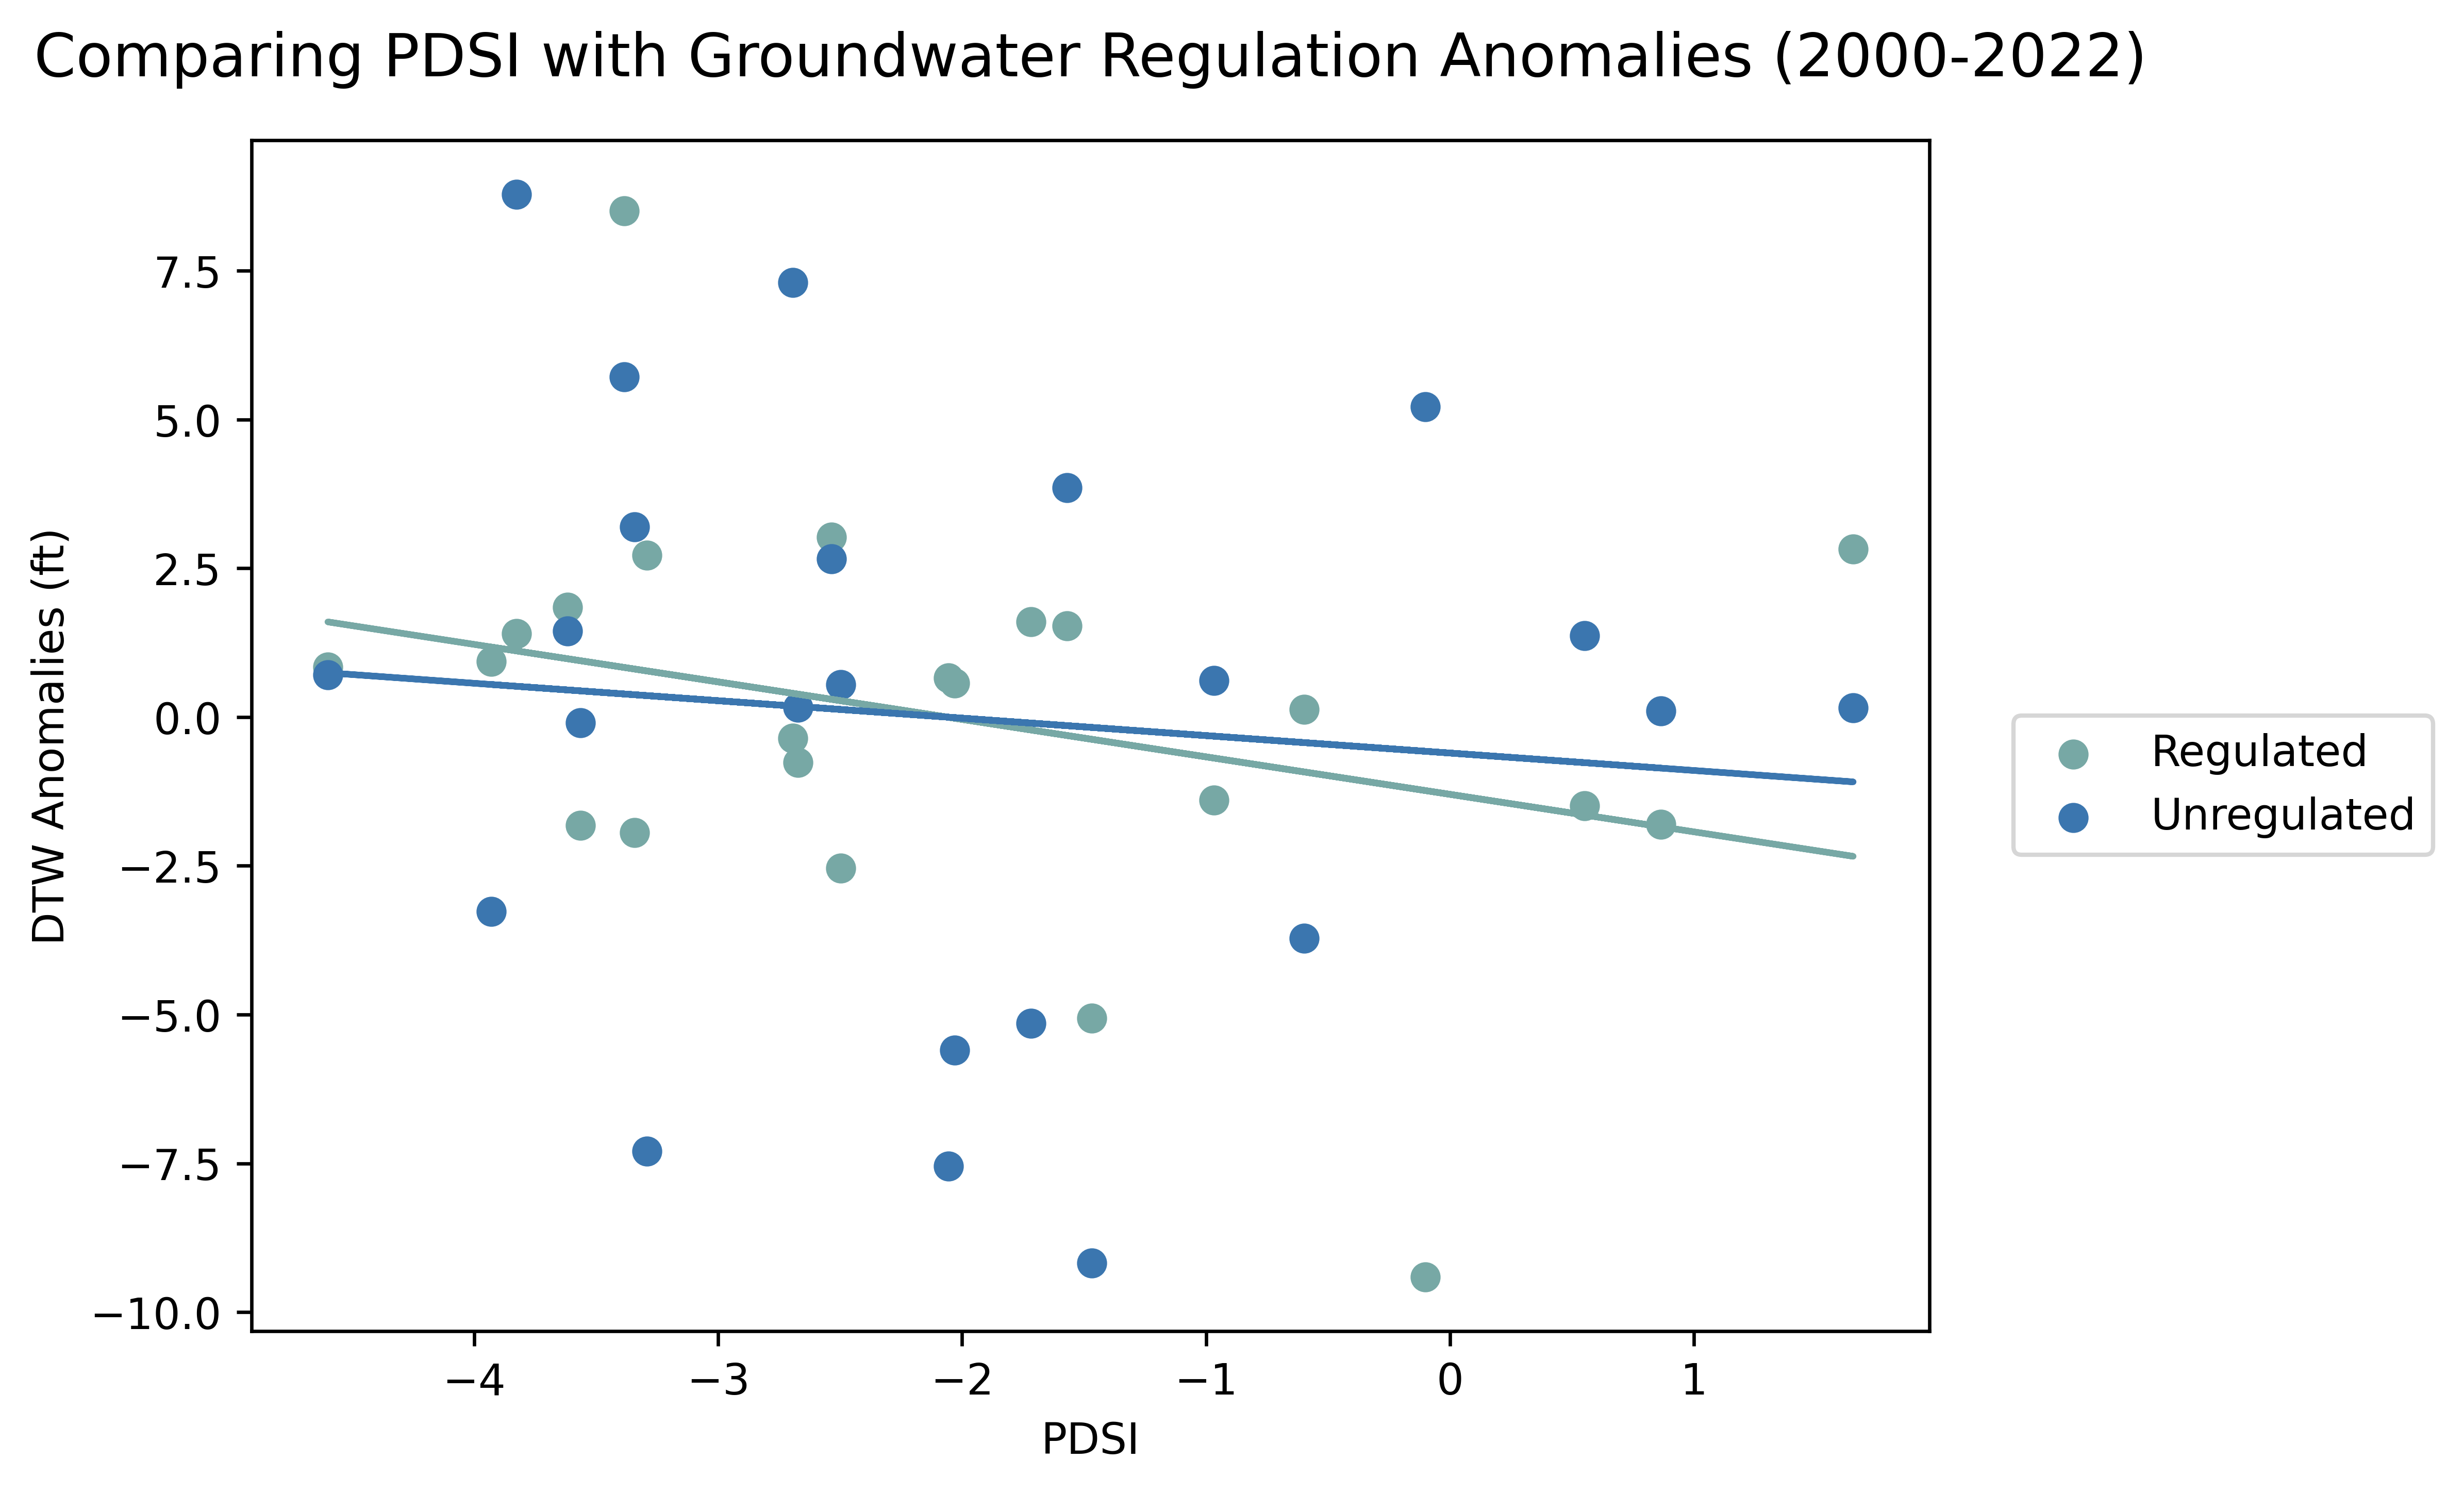

In [38]:
test_name = "Groundwater Regulation Anomalies ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices_reg
lag = 0
indice = 'PDSI'

betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
vert_axis = "DTW Anomalies (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,colors,betterlabels,vert_axis)
print(result)

For PHDI

Results for Groundwater Regulation Anomalies (2000-2022):
Kendall Correlation coefficient
 R:
  tau = -0.241
  pval = 0.1137
 U:
  tau = -0.162
  pval = 0.2944
Spearman Correlation coefficient
 R:
  rho = -0.313
  pval = 0.1456
 U:
  rho = -0.275
  pval = 0.2046
Pearson Correlation coefficient
 R:
  rsq = 0.046
  pval = 0.3253
 U:
  rsq = 0.019
  pval = 0.5346



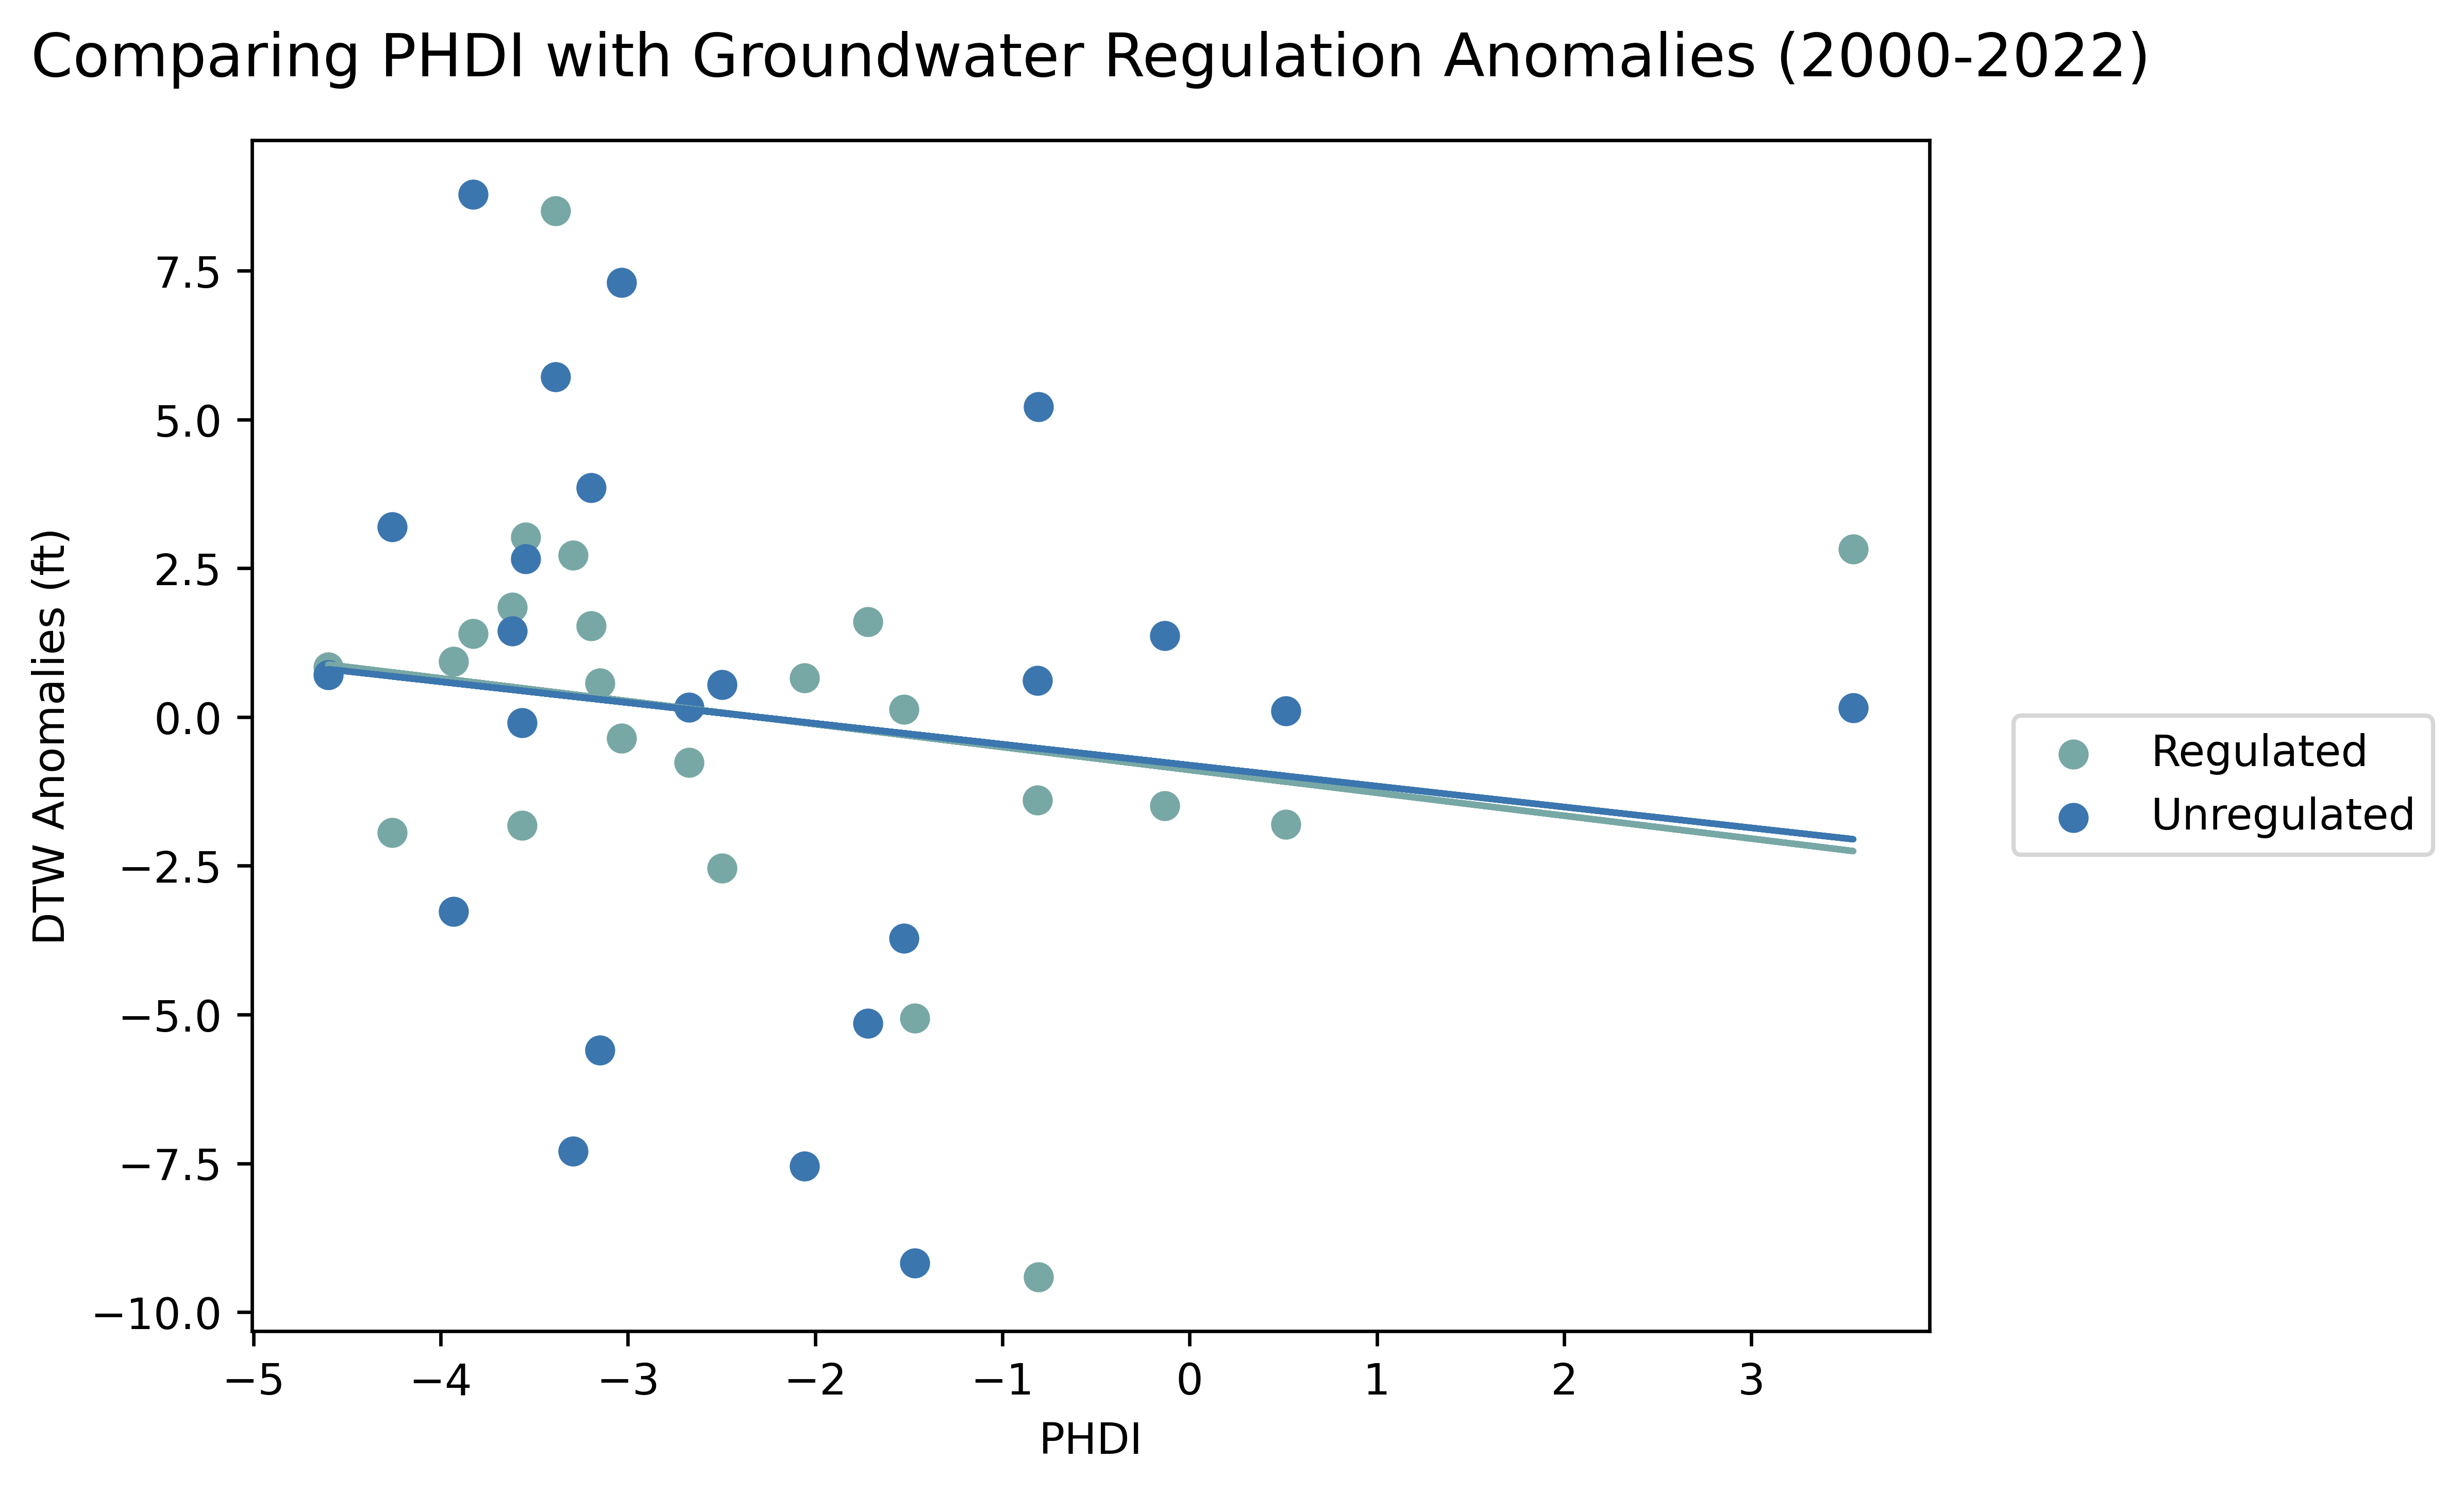

In [39]:
test_name = "Groundwater Regulation Anomalies ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices_reg
lag = 0
indice = 'PHDI'

betterlabels = ['Regulated','Unregulated'] 
colors=[cap, GWdom]
vert_axis = "DTW Anomalies (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,colors,betterlabels,vert_axis)
print(result)

Creating a timeseries plot of anomalies

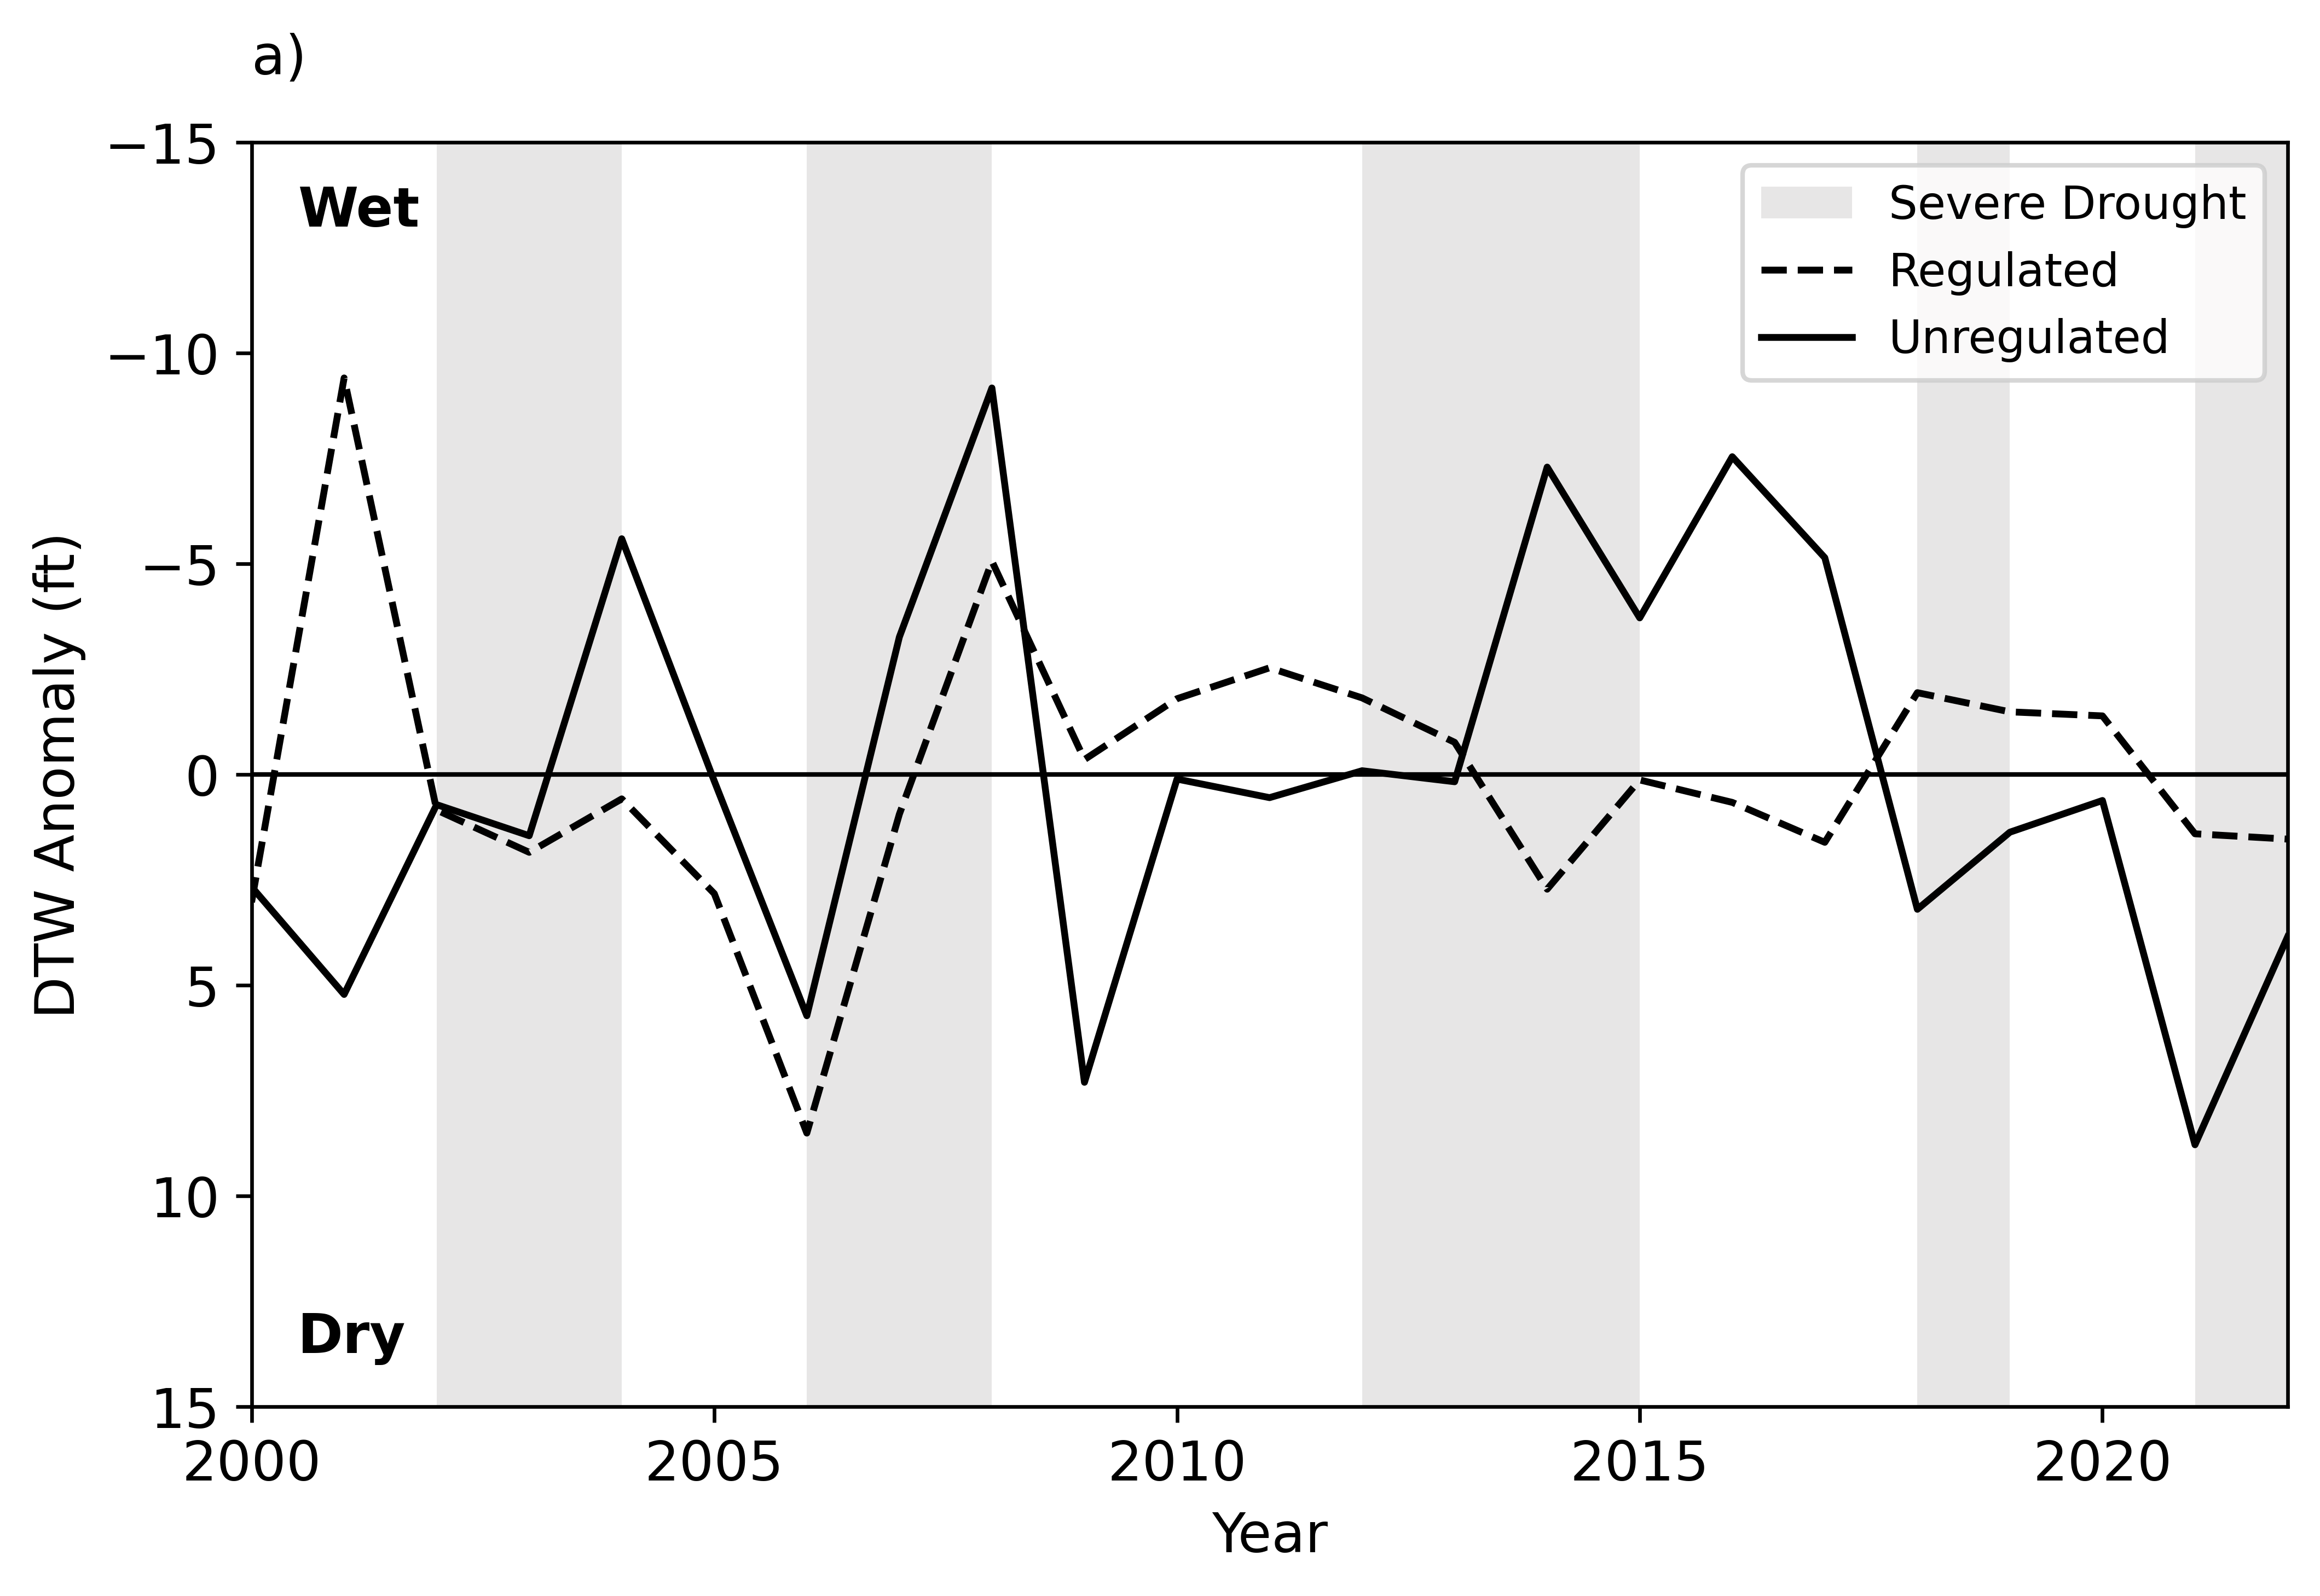

In [48]:
# For Depth to Water by regulation
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022
betterlabels = ['Regulated','Unregulated'] 

fig, ax = plt.subplots(1, 1, figsize = (8,5))

well_ylimit = 15 #ft
fsize = 12

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)


ax.plot(ds['R'],'--', label='Regulated', color='black', lw=1.5) 
ax.plot(ds['U'], label='Unregulated', color='black', lw=1.5) 

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(well_ylimit,-well_ylimit)
# ax.set_ylim(-12,15)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
ax.set_title('a)',loc='left',fontsize=fsize,pad=15)
ax.legend(loc='upper right')

# Adding text inside the plot
ax.text(min_yr+0.5, 1-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, well_ylimit-1, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')


plt.axhspan(0,0,color='black',lw=1)
plt.savefig(figurepath+'/Figure5a', bbox_inches = 'tight')

Calculating Max Drawdown (maximum anomaly in the drought period)

In [41]:
# %% Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'
# wlanalysis_period

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies
# ds

R         U
Status                        
Drought 3   1.843087  1.449180
Drought 4   8.505108  5.720432
Drought 5   2.717774  0.168324
Drought 6  -1.945220  3.194947
Drought 7   1.403271  8.782539
Normal-Wet  3.026903  7.300533

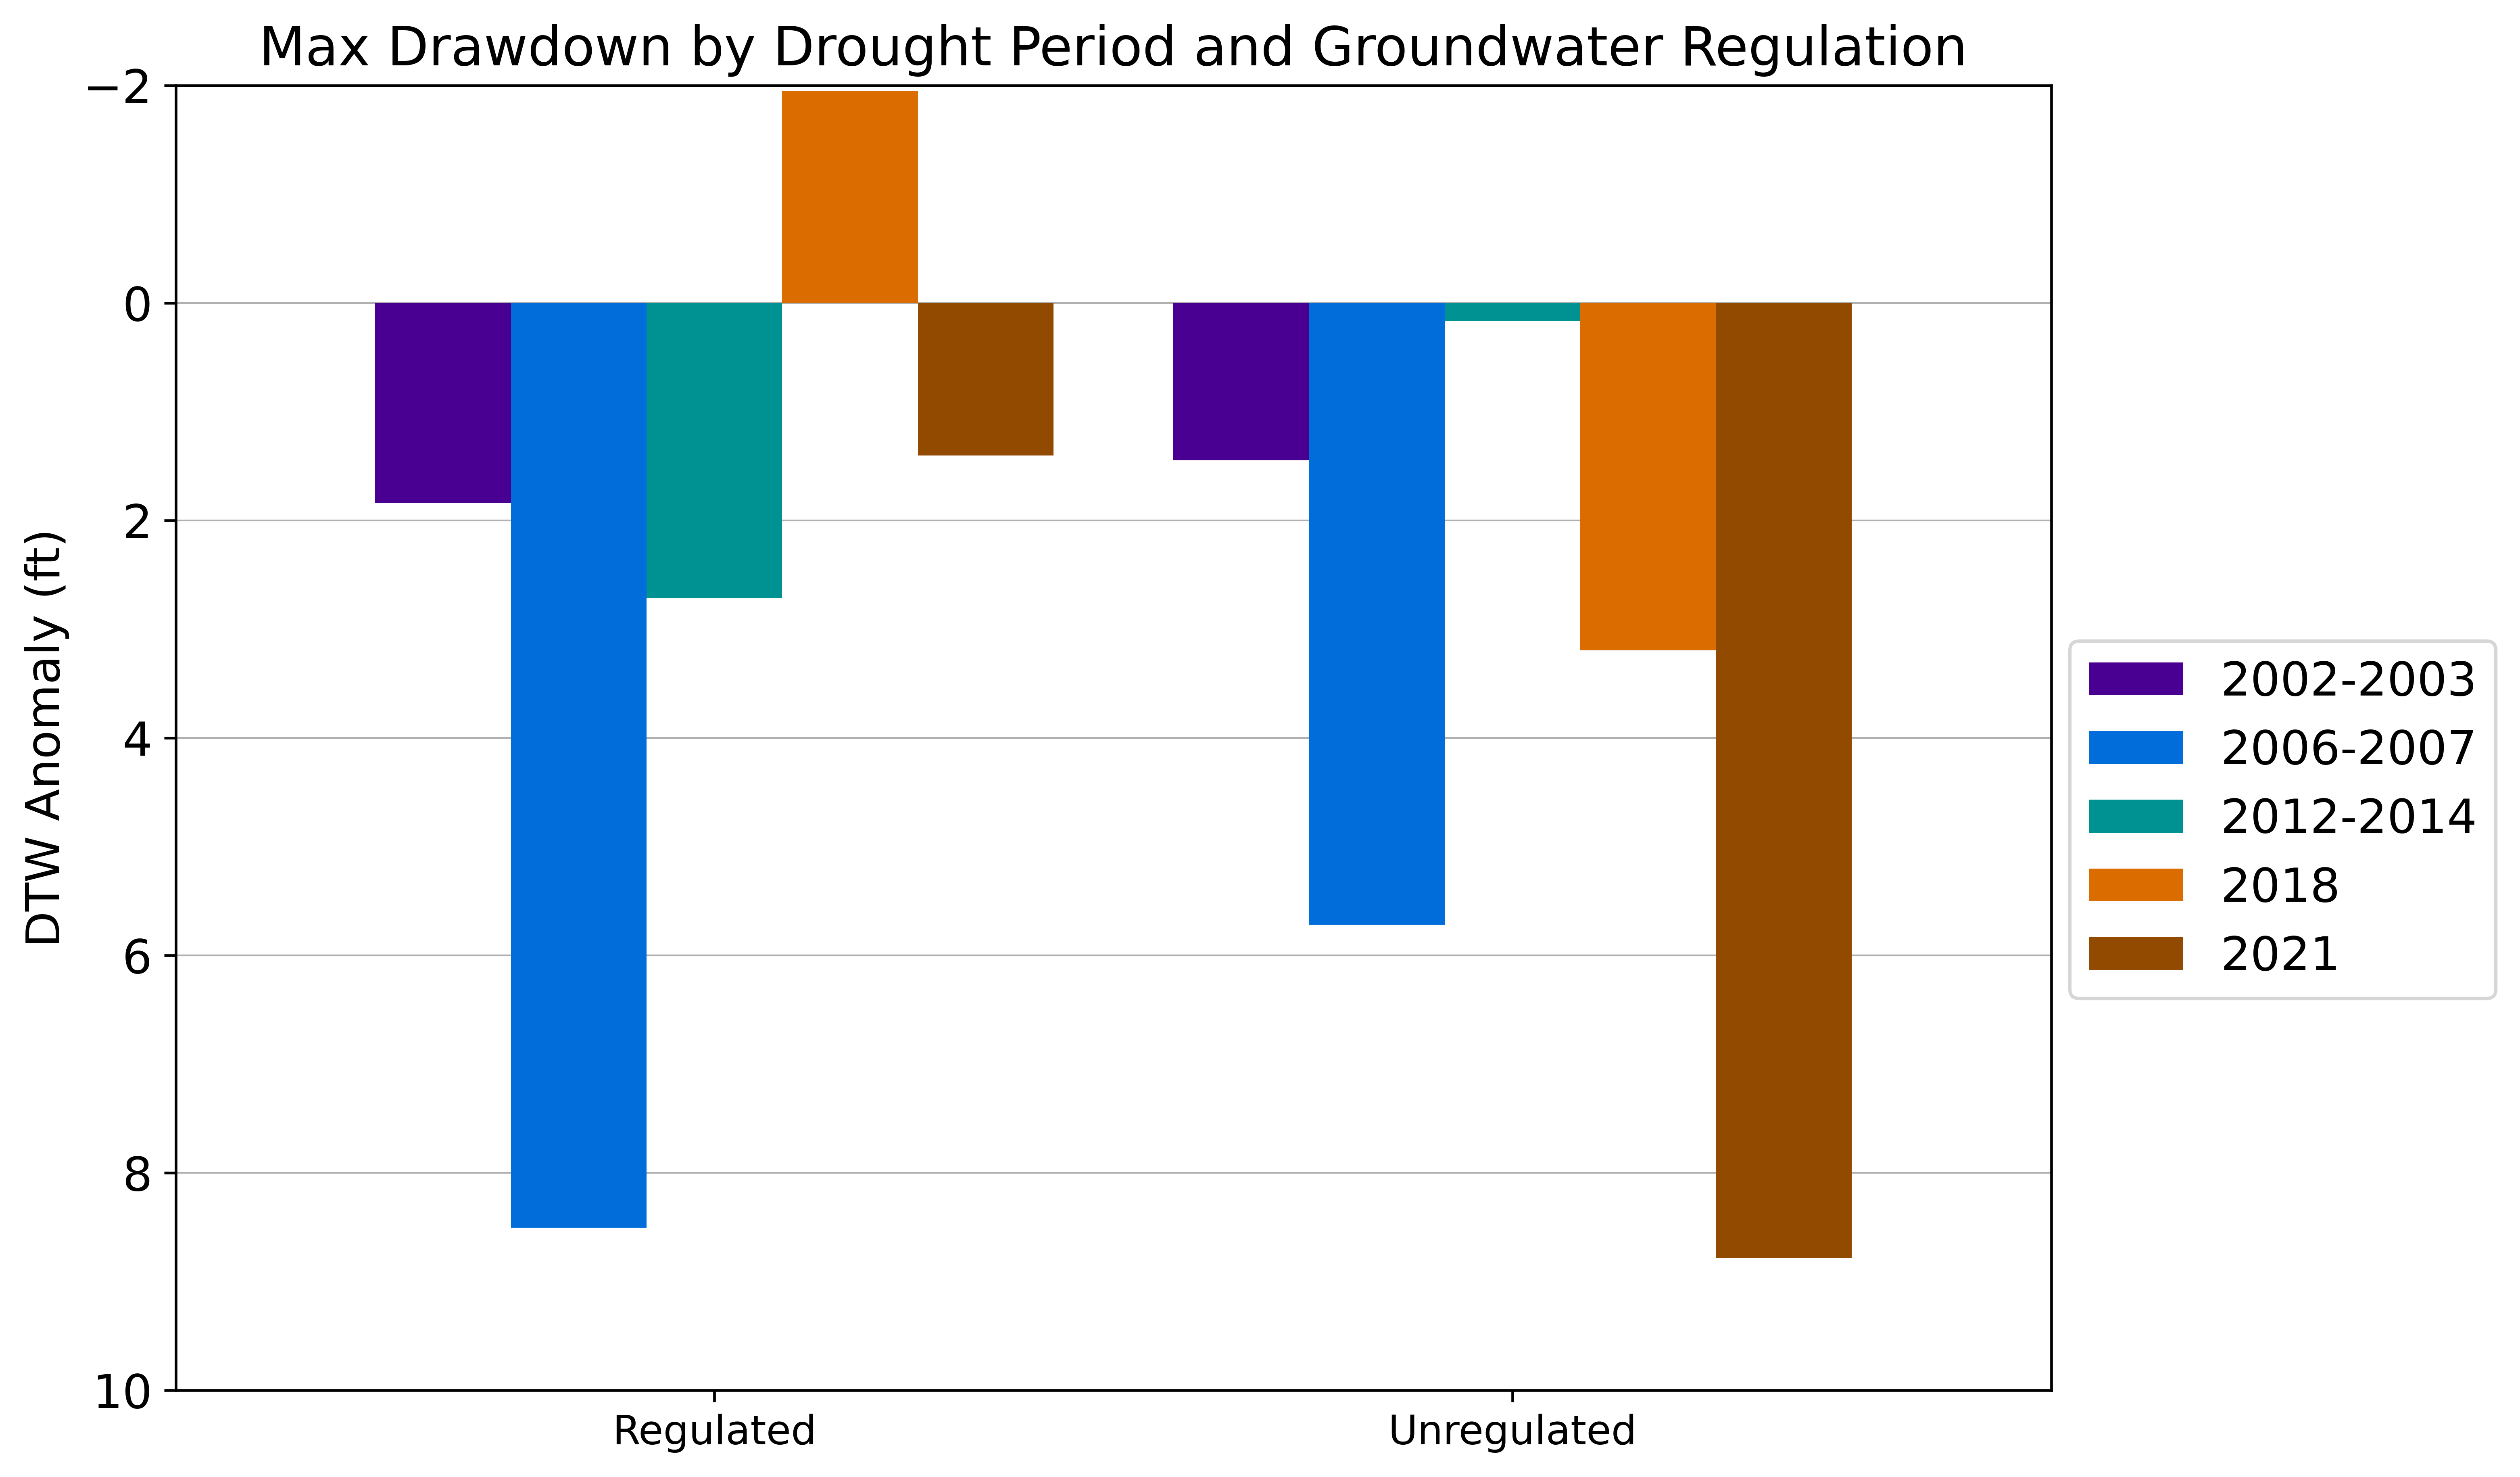

In [42]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Groundwater Regulation'

yearlabels = [
                # "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
betterlabels = ['Regulated','Unregulated']

dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies


group_colors = [cblind[5],cblind[6],cblind[2]
                ,cblind[12],cblind[11],cblind[10]
                # ,blind[0] #black
                ]

vertlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
plt.ylim([10,-2])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=0, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)


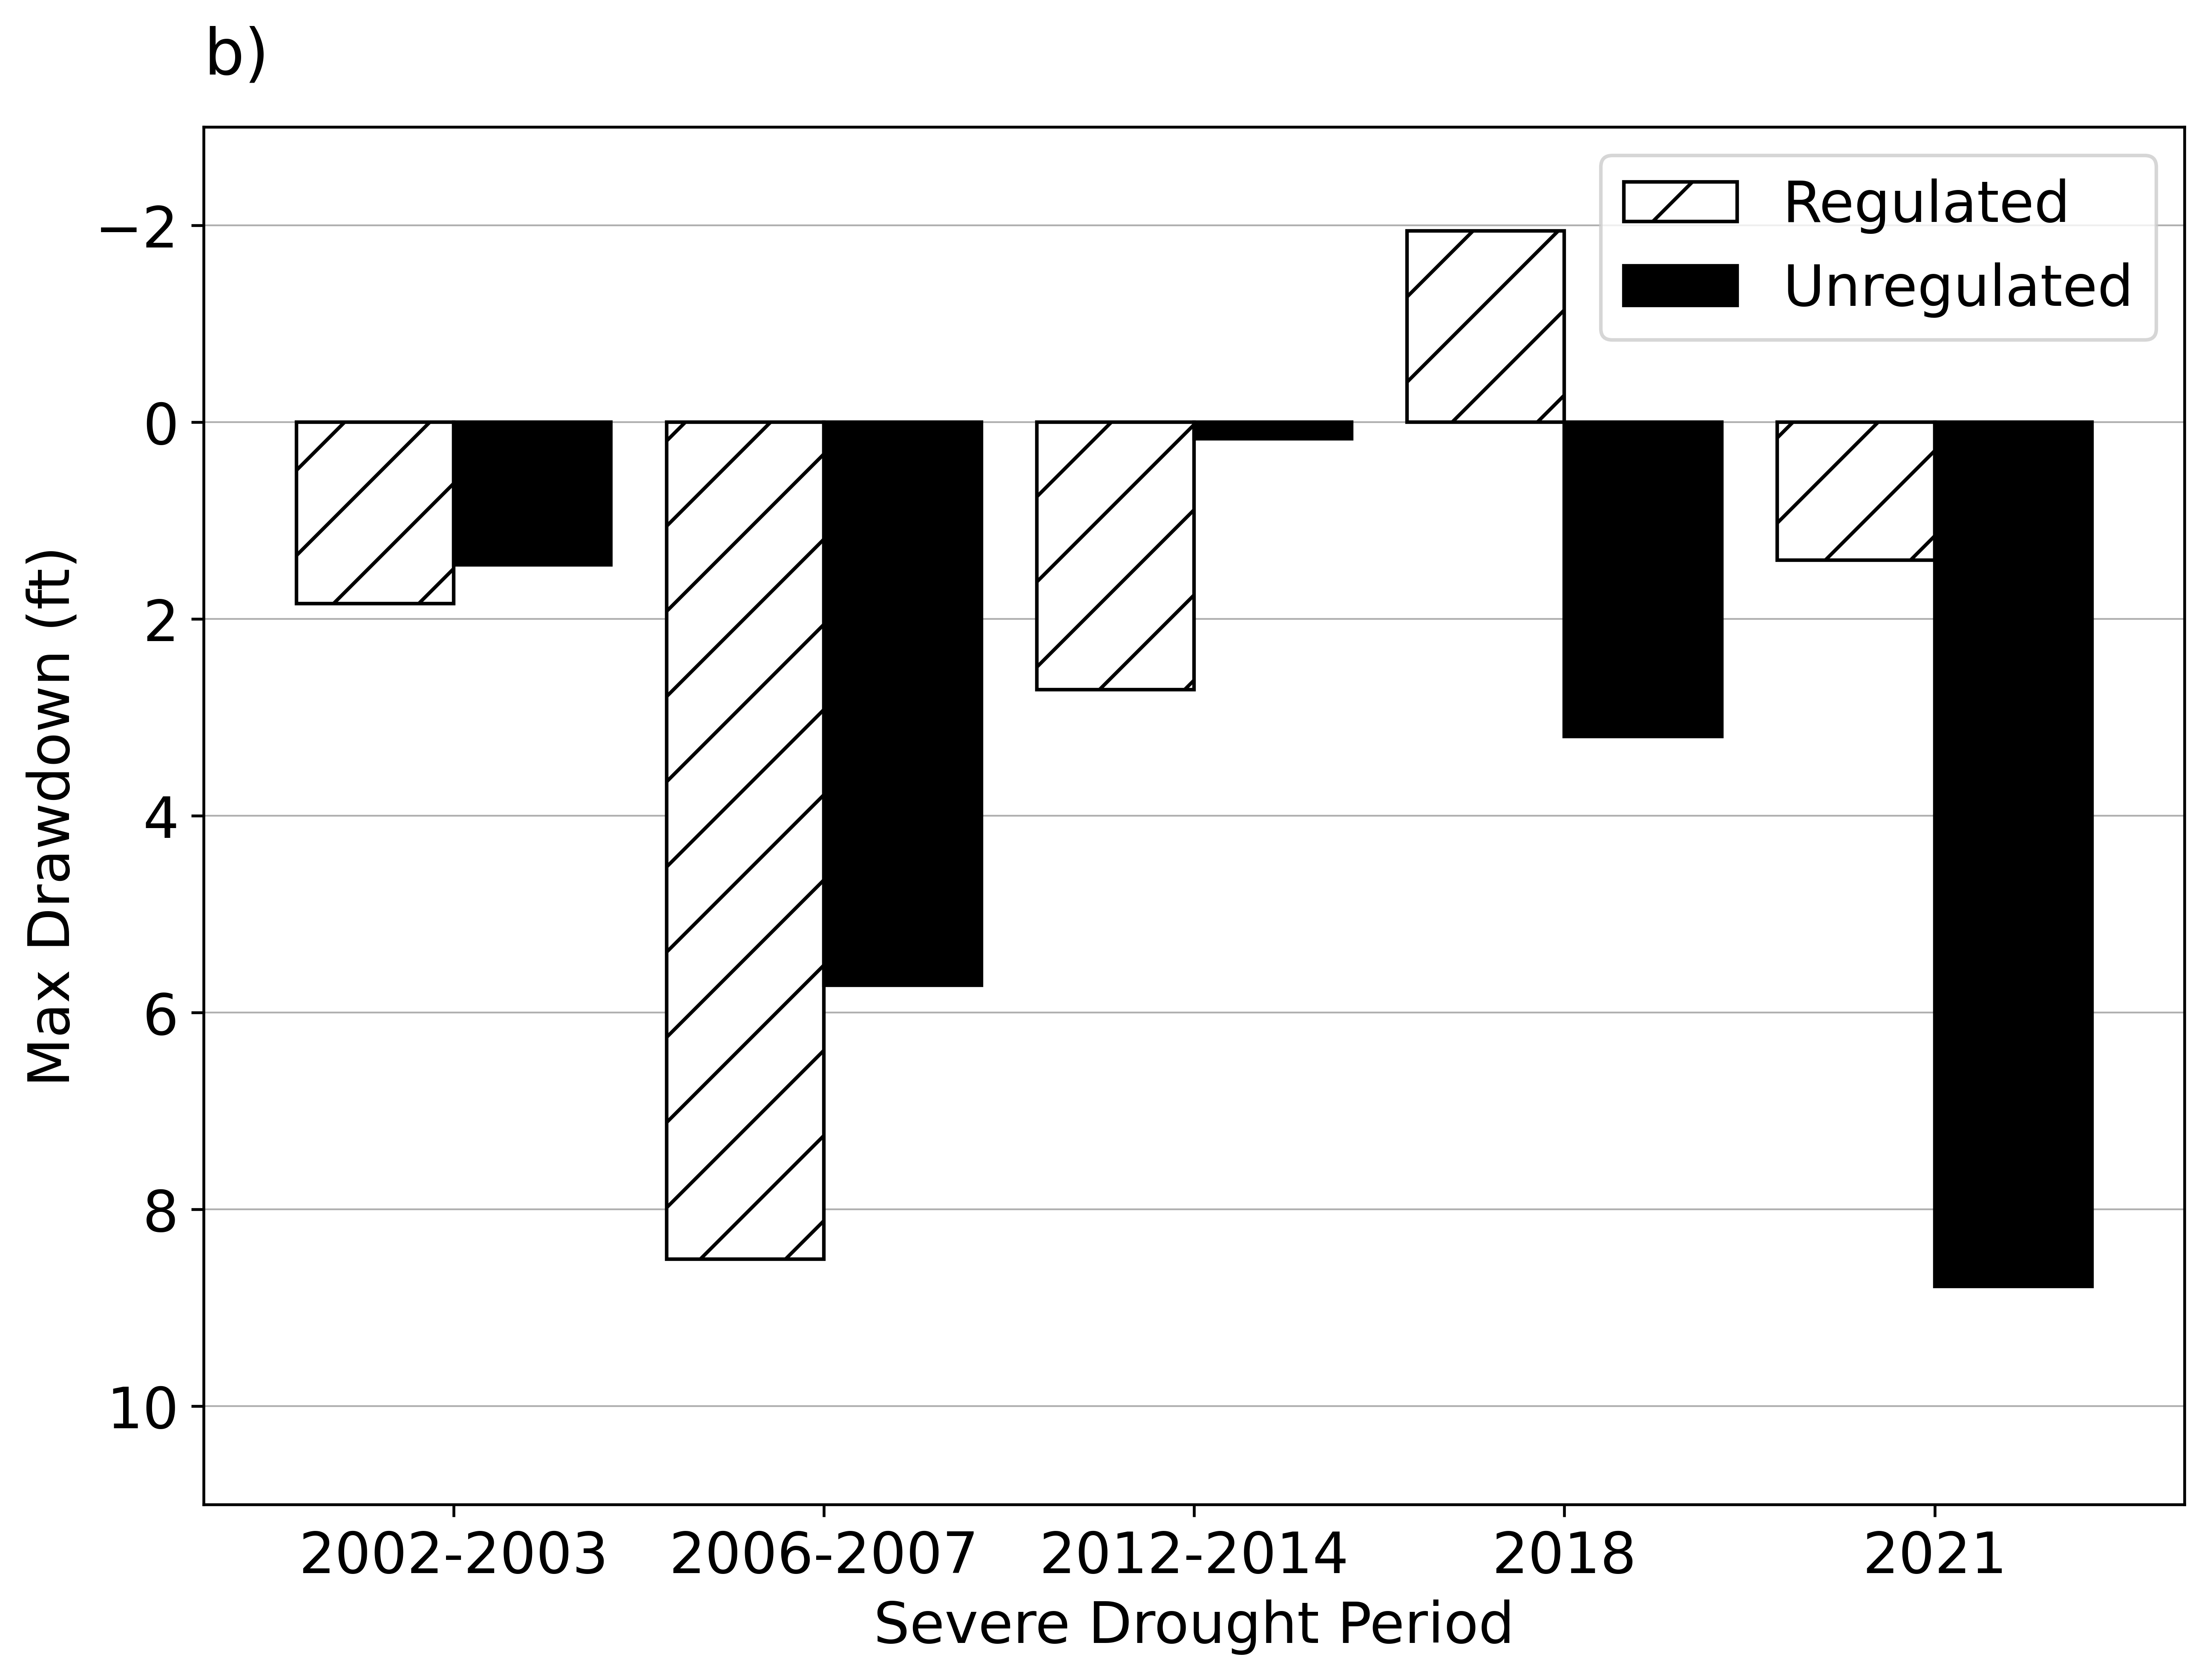

In [47]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Groundwater Regulation'

dtw_max_anomalies = dtw_max_anomalies.transpose()

group_colors = ['white','black']

vertlabel = 'Max Drawdown (ft)'
fsize = 16
well_ylimit = 10

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize,
        hatch = '/',
        edgecolor = 'black'
        )

# plt.title(name, fontsize = (fsize+2))
plt.title('b)', fontsize = (fsize+2),loc='left',pad=15)
plt.ylim([11,-3])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xlabel("Severe Drought Period", fontsize =fsize)
plt.xticks(rotation=0, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc= 'upper right' # [1.01,0.3]
           ,fontsize = fsize)
# plt.set_dpi(600)

plt.savefig(figurepath + '/Figure5b', bbox_inches='tight')

### For Access to Surface Water

In [49]:
cat_wl2 = cat_wl2_SW.copy()

Min_year_of_Study = 2000

wlanalysis_period = cat_wl2[(cat_wl2.index>=Min_year_of_Study)&(cat_wl2.index<=2022)]
del wlanalysis_period['Res']
del wlanalysis_period['Mix']
wlanalysis_period.head()

CAP          GW      No_CAP          SW
index                                                
2000   269.784028  221.997959  147.266309  100.654375
2001   249.664937  222.545888  160.683527   59.665000
2002   259.016096  218.404744  170.080169   77.343500
2003   261.884269  222.336519  164.495733   79.540393
2004   258.684416  217.119324  168.410180   84.221469

Reformatting the table so it's in the right order

In [50]:
blank = pd.DataFrame()
blank['SW'] = wlanalysis_period['SW']
blank['CAP'] = wlanalysis_period['CAP']
blank['GW'] = wlanalysis_period['GW']
blank['No_CAP'] = wlanalysis_period['No_CAP']
wlanalysis_period = blank

In [51]:
betterlabels = ['Local Co River'
                ,'CAP Co River'
                ,'Groundwater (Unregulated)'
                ,'Groundwater (Regulated)'
                ]

colors=[cap_secondary
        ,swdom
        , GWdom
        , mixed
        ]

Results for Access to Surface Water (2000-2022):
Kendall Correlation coefficient
 SW:
  tau = 0.091
  pval = 0.5653
 CAP:
  tau = -0.154
  pval = 0.3194
 GW:
  tau = -0.02
  pval = 0.9168
 No_CAP:
  tau = -0.233
  pval = 0.1265
Spearman Correlation coefficient
 SW:
  rho = 0.11
  pval = 0.6183
 CAP:
  rho = -0.222
  pval = 0.3079
 GW:
  rho = -0.009
  pval = 0.9679
 No_CAP:
  rho = -0.34
  pval = 0.1125
Pearson Correlation coefficient
 SW:
  rsq = 0.0
  pval = 0.96
 CAP:
  rsq = 0.041
  pval = 0.3565
 GW:
  rsq = 0.001
  pval = 0.8635
 No_CAP:
  rsq = 0.066
  pval = 0.2383



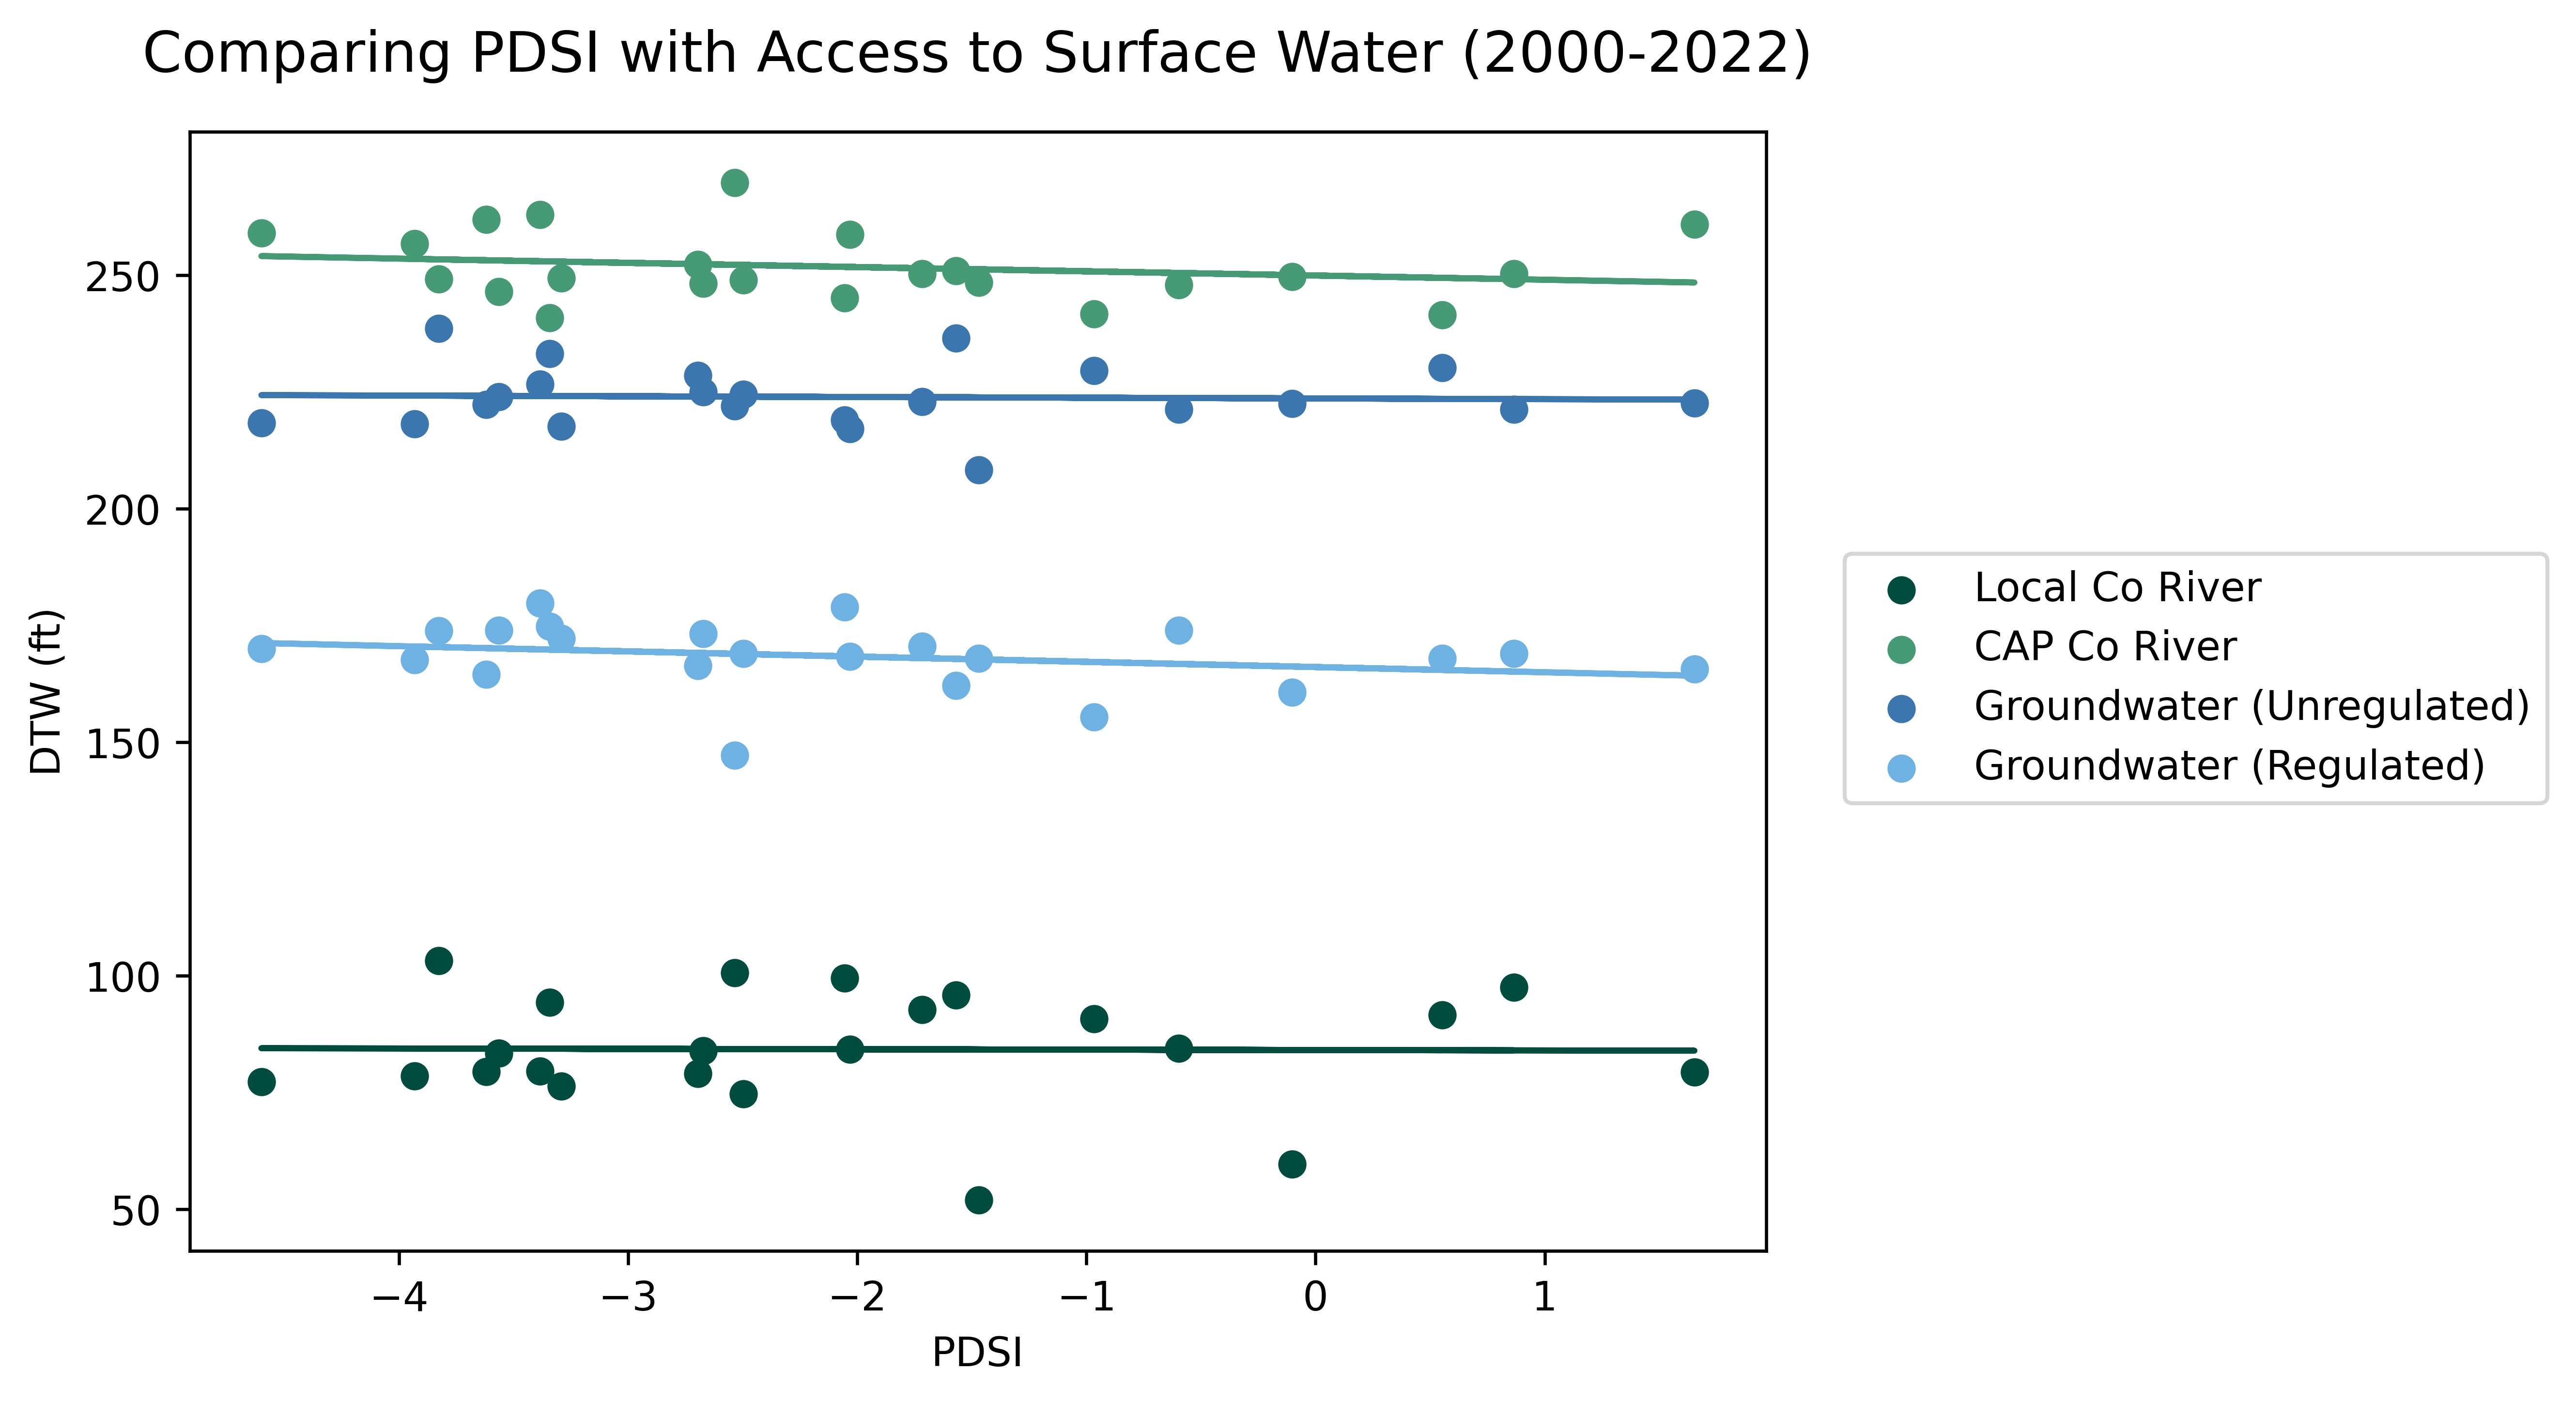

In [52]:
test_name = "Access to Surface Water ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = wlanalysis_period
drought = drought_indices_reg
lag = 0
indice = 'PDSI'

vert_axis = "DTW (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,colors,betterlabels,vert_axis)
print(result)

In [53]:
# 1. Anomaly's
ds = wlanalysis_period.copy()
columns = ds.columns
column_list = ds.columns.tolist()

dtw_anomalys = pd.DataFrame()
for i in column_list:
        # Subtracting against the mean
        # dtw_anomalys[i] = wlanalysis_period[i] - wlanalysis_period[i].mean()
        
        # Subtracting against the slope
        df = ds[i]
        y=np.array(df.values, dtype=float)
        x=np.array(pd.to_datetime(df).index.values, dtype=float)
        slope, intercept, r_value, p_value, std_err = sp.linregress(x,y)
        # print(y)
        # slope, intercept = sp.linregress(x,y) 
        # dtw_anomalys[i] = wlanalysis_period[i] - ((wlanalysis_period.index*slope) + intercept)
        trend_df[i] = (wlanalysis_period.index*slope) + intercept
        dtw_anomalys[i] = wlanalysis_period[i] - trend_df[i]

dtw_anomalys.head()


SW        CAP        GW     No_CAP
index                                           
2000   26.629045   8.718704  4.541103 -17.708473
2001  -15.293860 -10.557954  4.499824  -4.604201
2002    1.451110  -0.364361 -0.230529   4.479497
2003    2.714473   3.346244  3.112037  -1.417885
2004    6.462019   0.988824 -2.694365   2.183617

Results for Access to Surface Water (2000-2022):
Kendall Correlation coefficient
 SW:
  tau = -0.091
  pval = 0.5653
 CAP:
  tau = -0.146
  pval = 0.3457
 GW:
  tau = -0.107
  pval = 0.4966
 No_CAP:
  tau = -0.281
  pval = 0.064
Spearman Correlation coefficient
 SW:
  rho = -0.113
  pval = 0.6088
 CAP:
  rho = -0.244
  pval = 0.2617
 GW:
  rho = -0.16
  pval = 0.4656
 No_CAP:
  rho = -0.424
  pval = 0.0438
Pearson Correlation coefficient
 SW:
  rsq = 0.004
  pval = 0.7832
 CAP:
  rsq = 0.047
  pval = 0.3208
 GW:
  rsq = 0.011
  pval = 0.6279
 No_CAP:
  rsq = 0.086
  pval = 0.1756



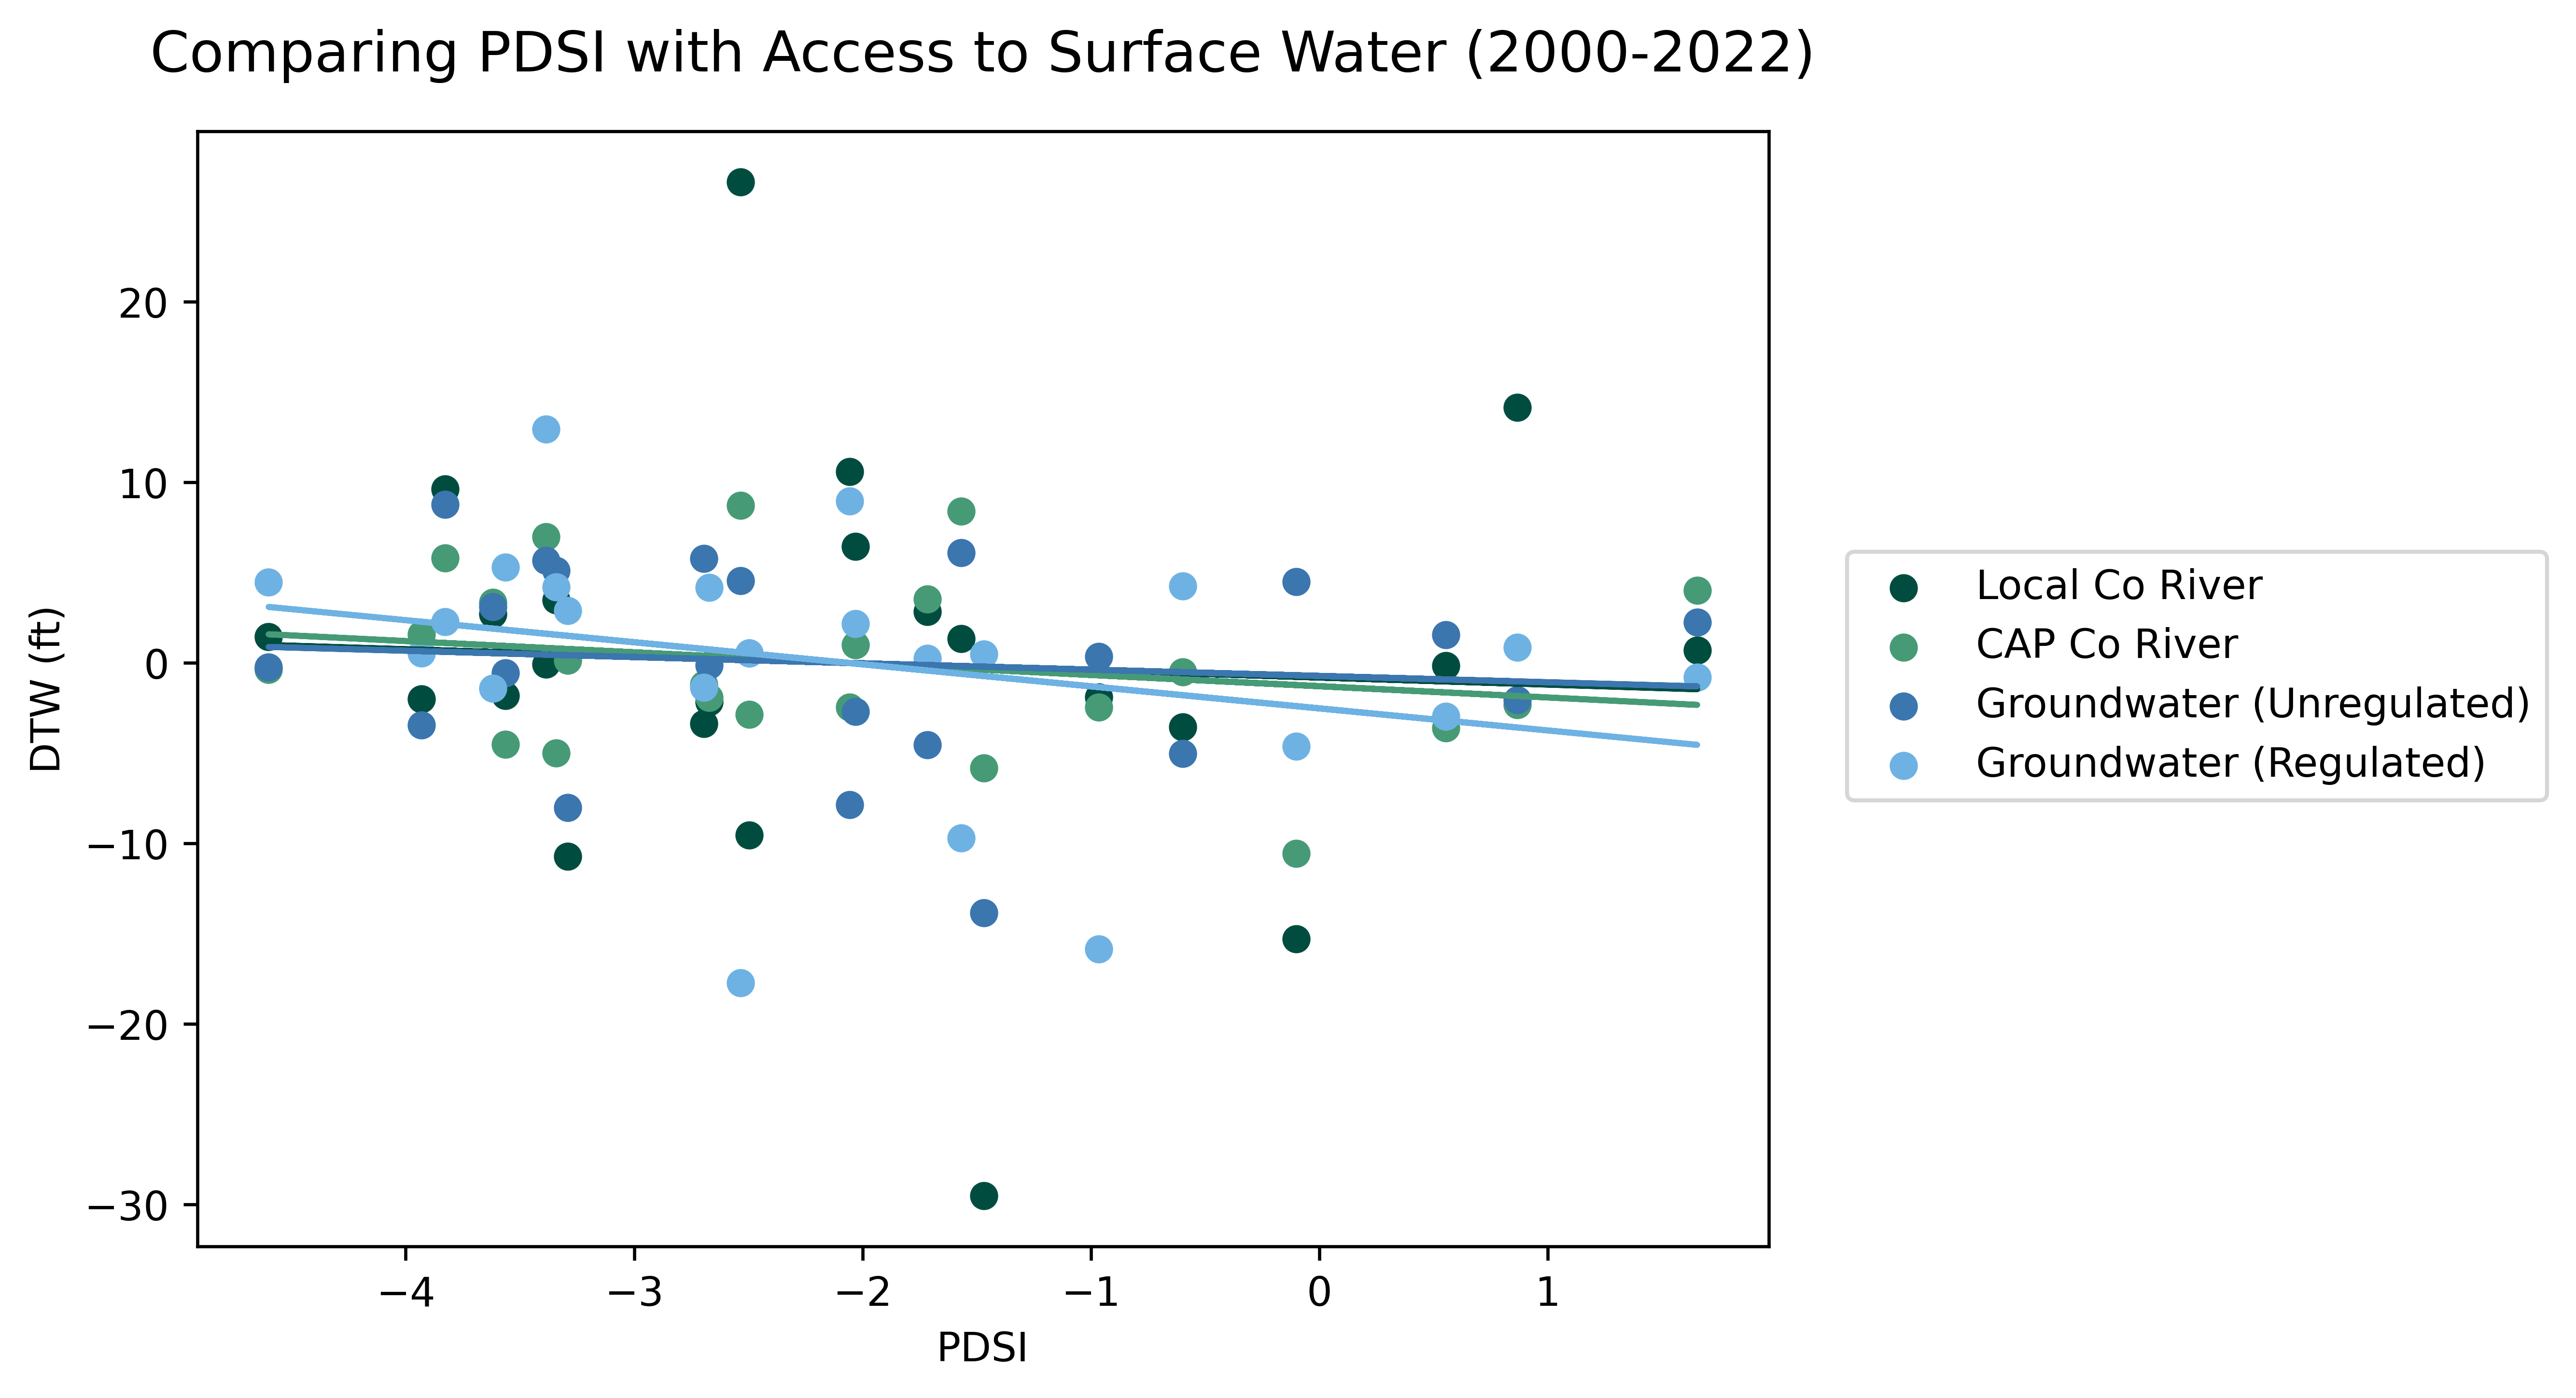

In [54]:
test_name = "Access to Surface Water ("+str(Min_year_of_Study)+"-"+str(Max_year_of_Study)+")"
ds = dtw_anomalys
drought = drought_indices_reg
lag = 0
indice = 'PDSI'

vert_axis = "DTW (ft)"

result = cf.correlation_test(ds, drought, indice, lag,test_name,colors,betterlabels,vert_axis)
print(result)

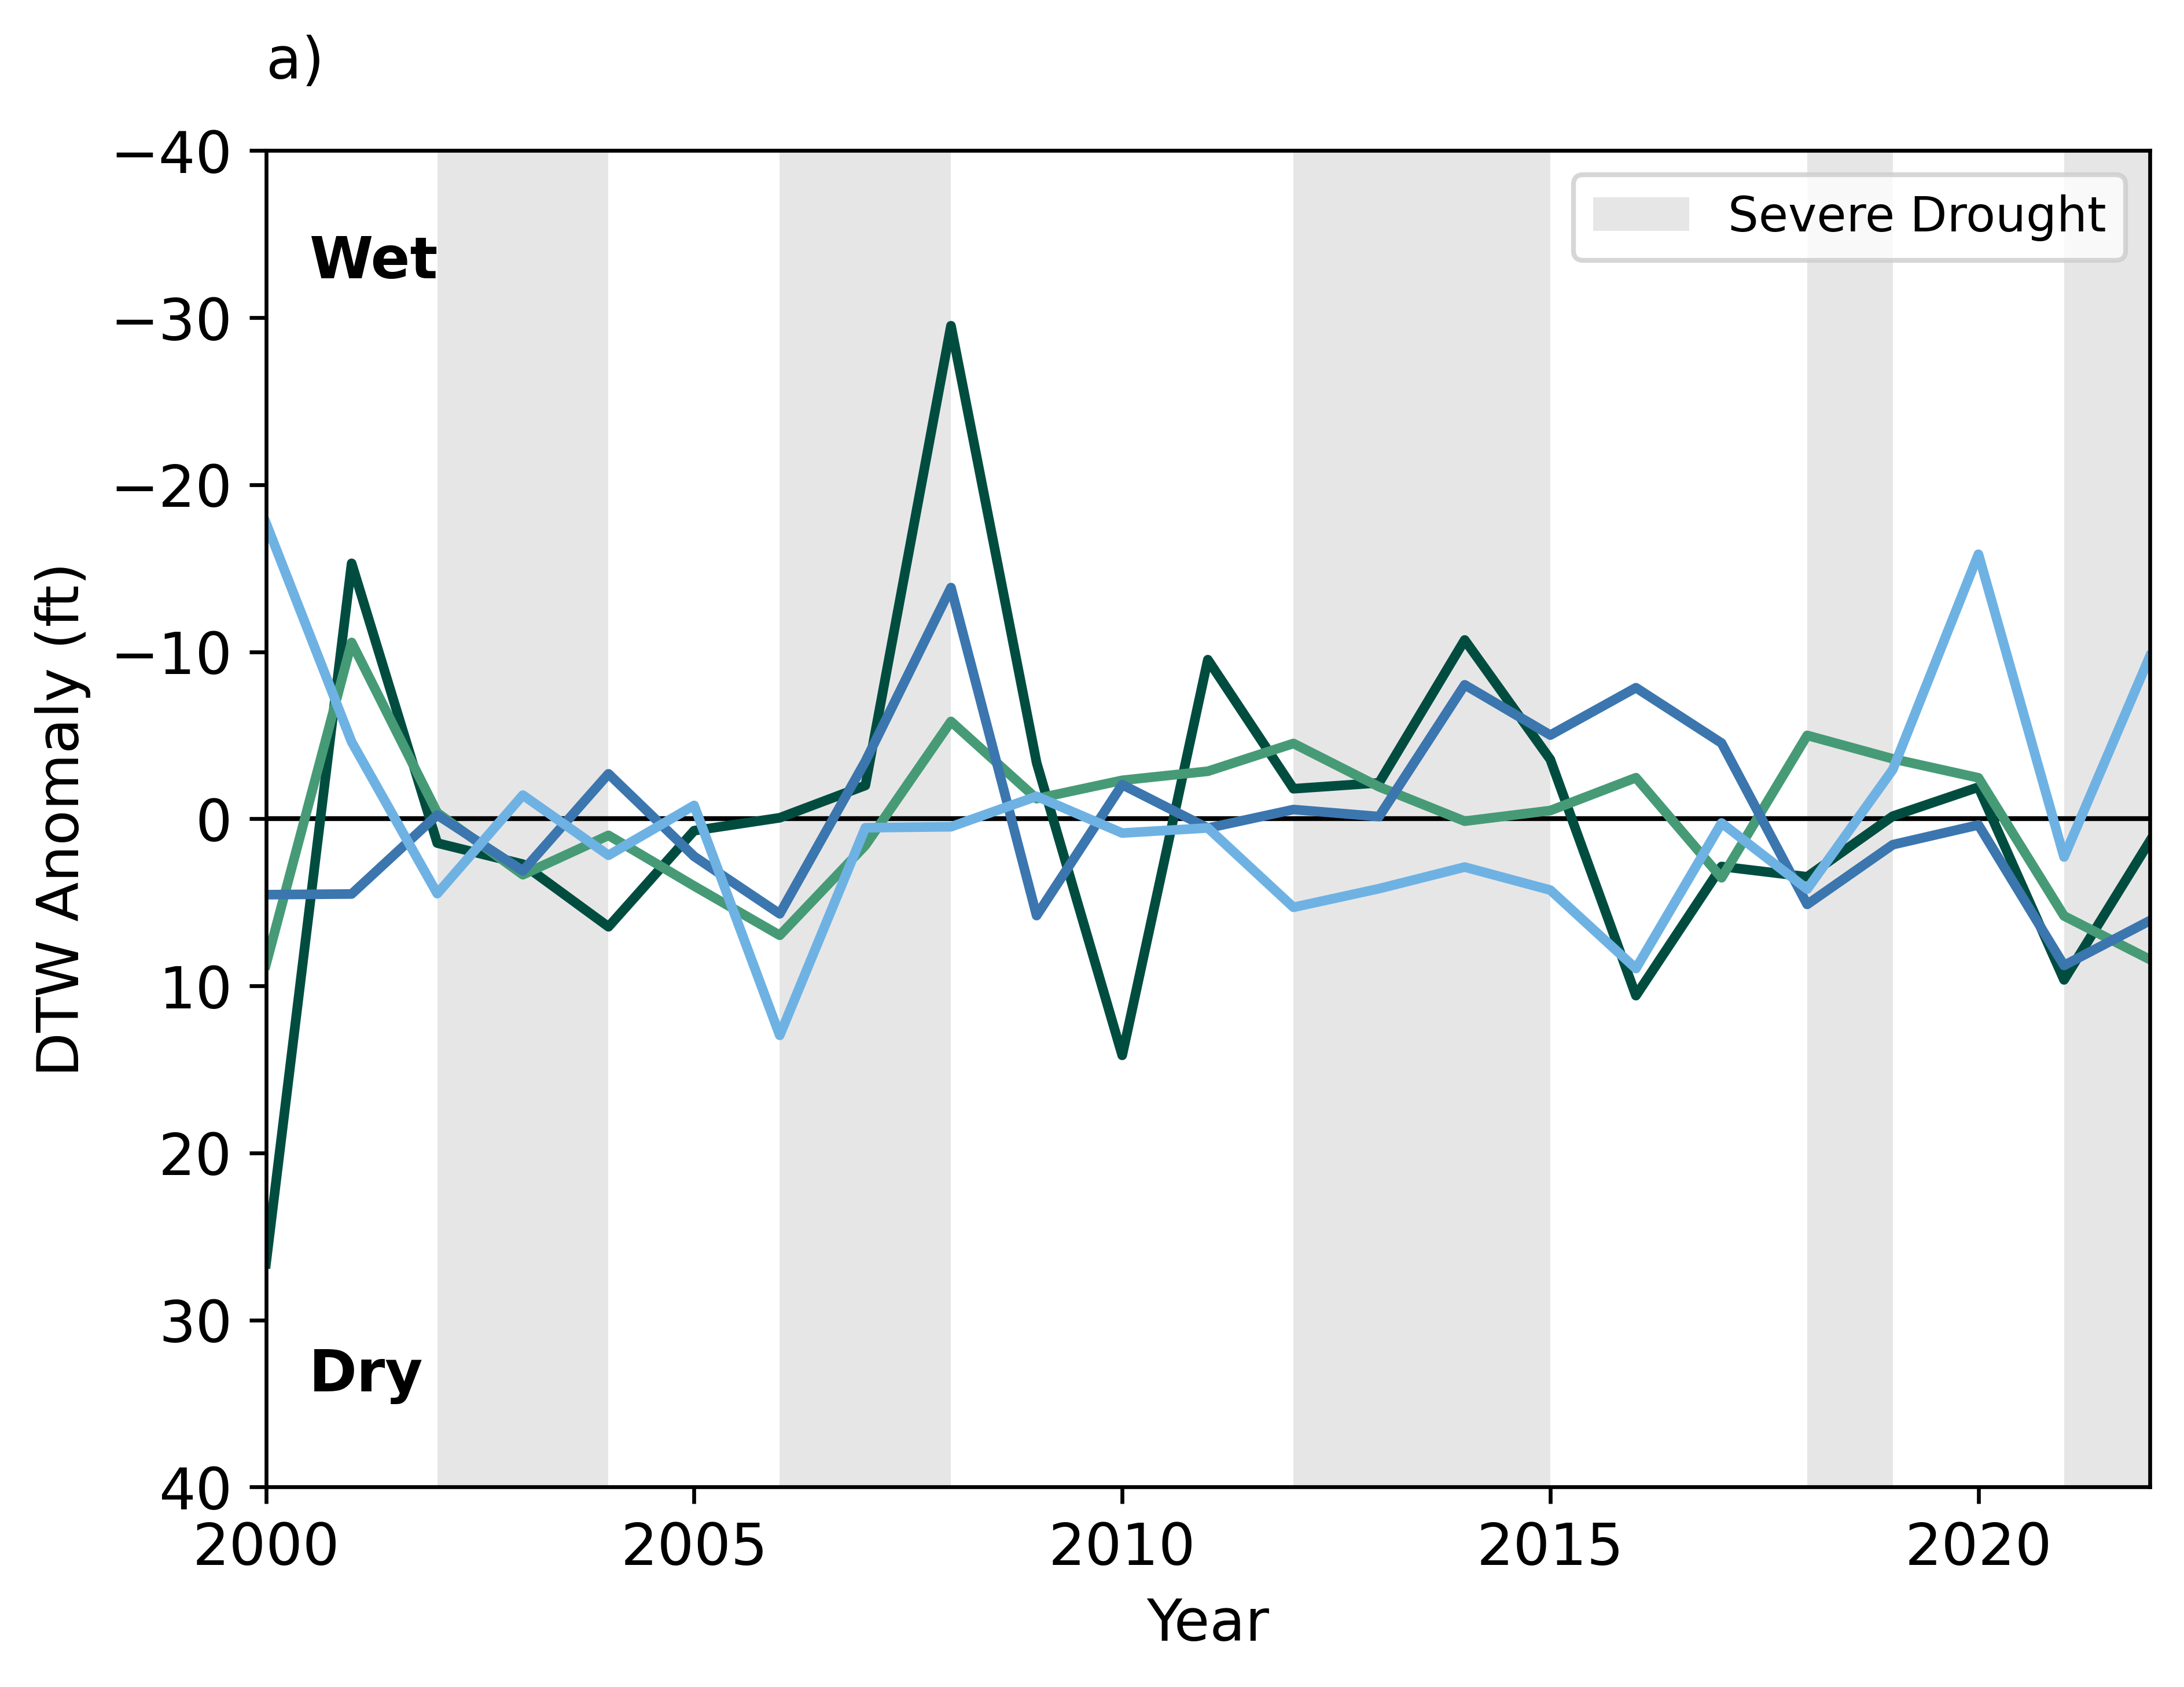

In [60]:
ds = dtw_anomalys
min_yr = 2000
mx_yr = 2022

fig, ax = plt.subplots(1, 1, figsize = (7,5))

well_ylimit = 40 #ft
fsize = 12

# Severe Drought Shading
ax.axvspan(DROUGHT_YEARS[3][0], DROUGHT_YEARS[3][1]+1, color=drought_color, alpha=0.5, lw=0
            , label="Severe Drought"
            )
ax.axvspan(DROUGHT_YEARS[4][0], DROUGHT_YEARS[4][1]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[5][0], DROUGHT_YEARS[5][2]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[6][0], DROUGHT_YEARS[6][0]+1, color=drought_color, alpha=0.5, lw=0)
ax.axvspan(DROUGHT_YEARS[7][0], DROUGHT_YEARS[7][0]+1, color=drought_color, alpha=0.5, lw=0)

ax.plot(ds['SW'], 
        # label=betterlabels[0], 
        color=cap_secondary,zorder=2,lw=2) 
ax.plot(ds['CAP'], 
        # label=betterlabels[1], 
        color=swdom,zorder=2,lw=2)
ax.plot(ds['GW'], 
        # label=betterlabels[2], 
        color=GWdom,zorder=2,lw=2)  
ax.plot(ds['No_CAP'], 
        # label=betterlabels[3], 
        color=mixed,zorder=2,lw=2)

# Set x ticks to every 5 years
xticks = np.arange(min_yr, mx_yr + 1, 5)
ax.set_xticks(xticks)

ax.set_xlim(min_yr,mx_yr)
ax.set_ylim(well_ylimit,-well_ylimit)
# ax.set_ylim(-32,30)
# ax.grid(True)
# ax.grid(visible=True,which='major')
# ax.grid(which='minor',color='#EEEEEE', lw=0.8)
ax.tick_params(axis='x', labelsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)
ax.set_xlabel('Year', fontsize=fsize)
ax.set_ylabel('DTW Anomaly (ft)',fontsize=fsize)
# ax.minorticks_on()
fig.set_dpi(600.0)
ax.set_title('a)',fontsize = fsize,loc='left',pad=15)
ax.legend(loc='upper right')

# Adding text inside the plot
ax.text(min_yr+0.5, 5-well_ylimit, 'Wet', fontsize=fsize, fontweight='bold', ha='left', va='top')
ax.text(min_yr+0.5, well_ylimit-5, 'Dry', fontsize=fsize, fontweight='bold', ha='left', va='bottom')


plt.axhspan(0,0,color='black',lw=1)
plt.savefig(figurepath+'/Figure6a', bbox_inches = 'tight')

In [56]:
# Average Anomalie for drought periods
ds = dtw_anomalys.copy()
columns = ds.columns
column_list = ds.columns.tolist()

ds['Status'] = 'Normal-Wet'

for x,y in DROUGHT_YEARS.items():
        ds.loc[y, 'Status'] = 'Drought '+str(x)


dtw_max_anomalies = ds.groupby(['Status']).max()
dtw_max_anomalies

SW       CAP        GW     No_CAP
Status                                              
Drought 3    2.714473  3.346244  3.112037   4.479497
Drought 4   -0.062208  6.973343  5.686512  12.961784
Drought 5   -1.800598  0.141770 -0.133442   5.296930
Drought 6    3.471135 -4.994715  5.125245   4.209225
Drought 7    9.640547  5.814141  8.776041   2.287804
Normal-Wet  26.629045  8.718704  6.101838   8.963423

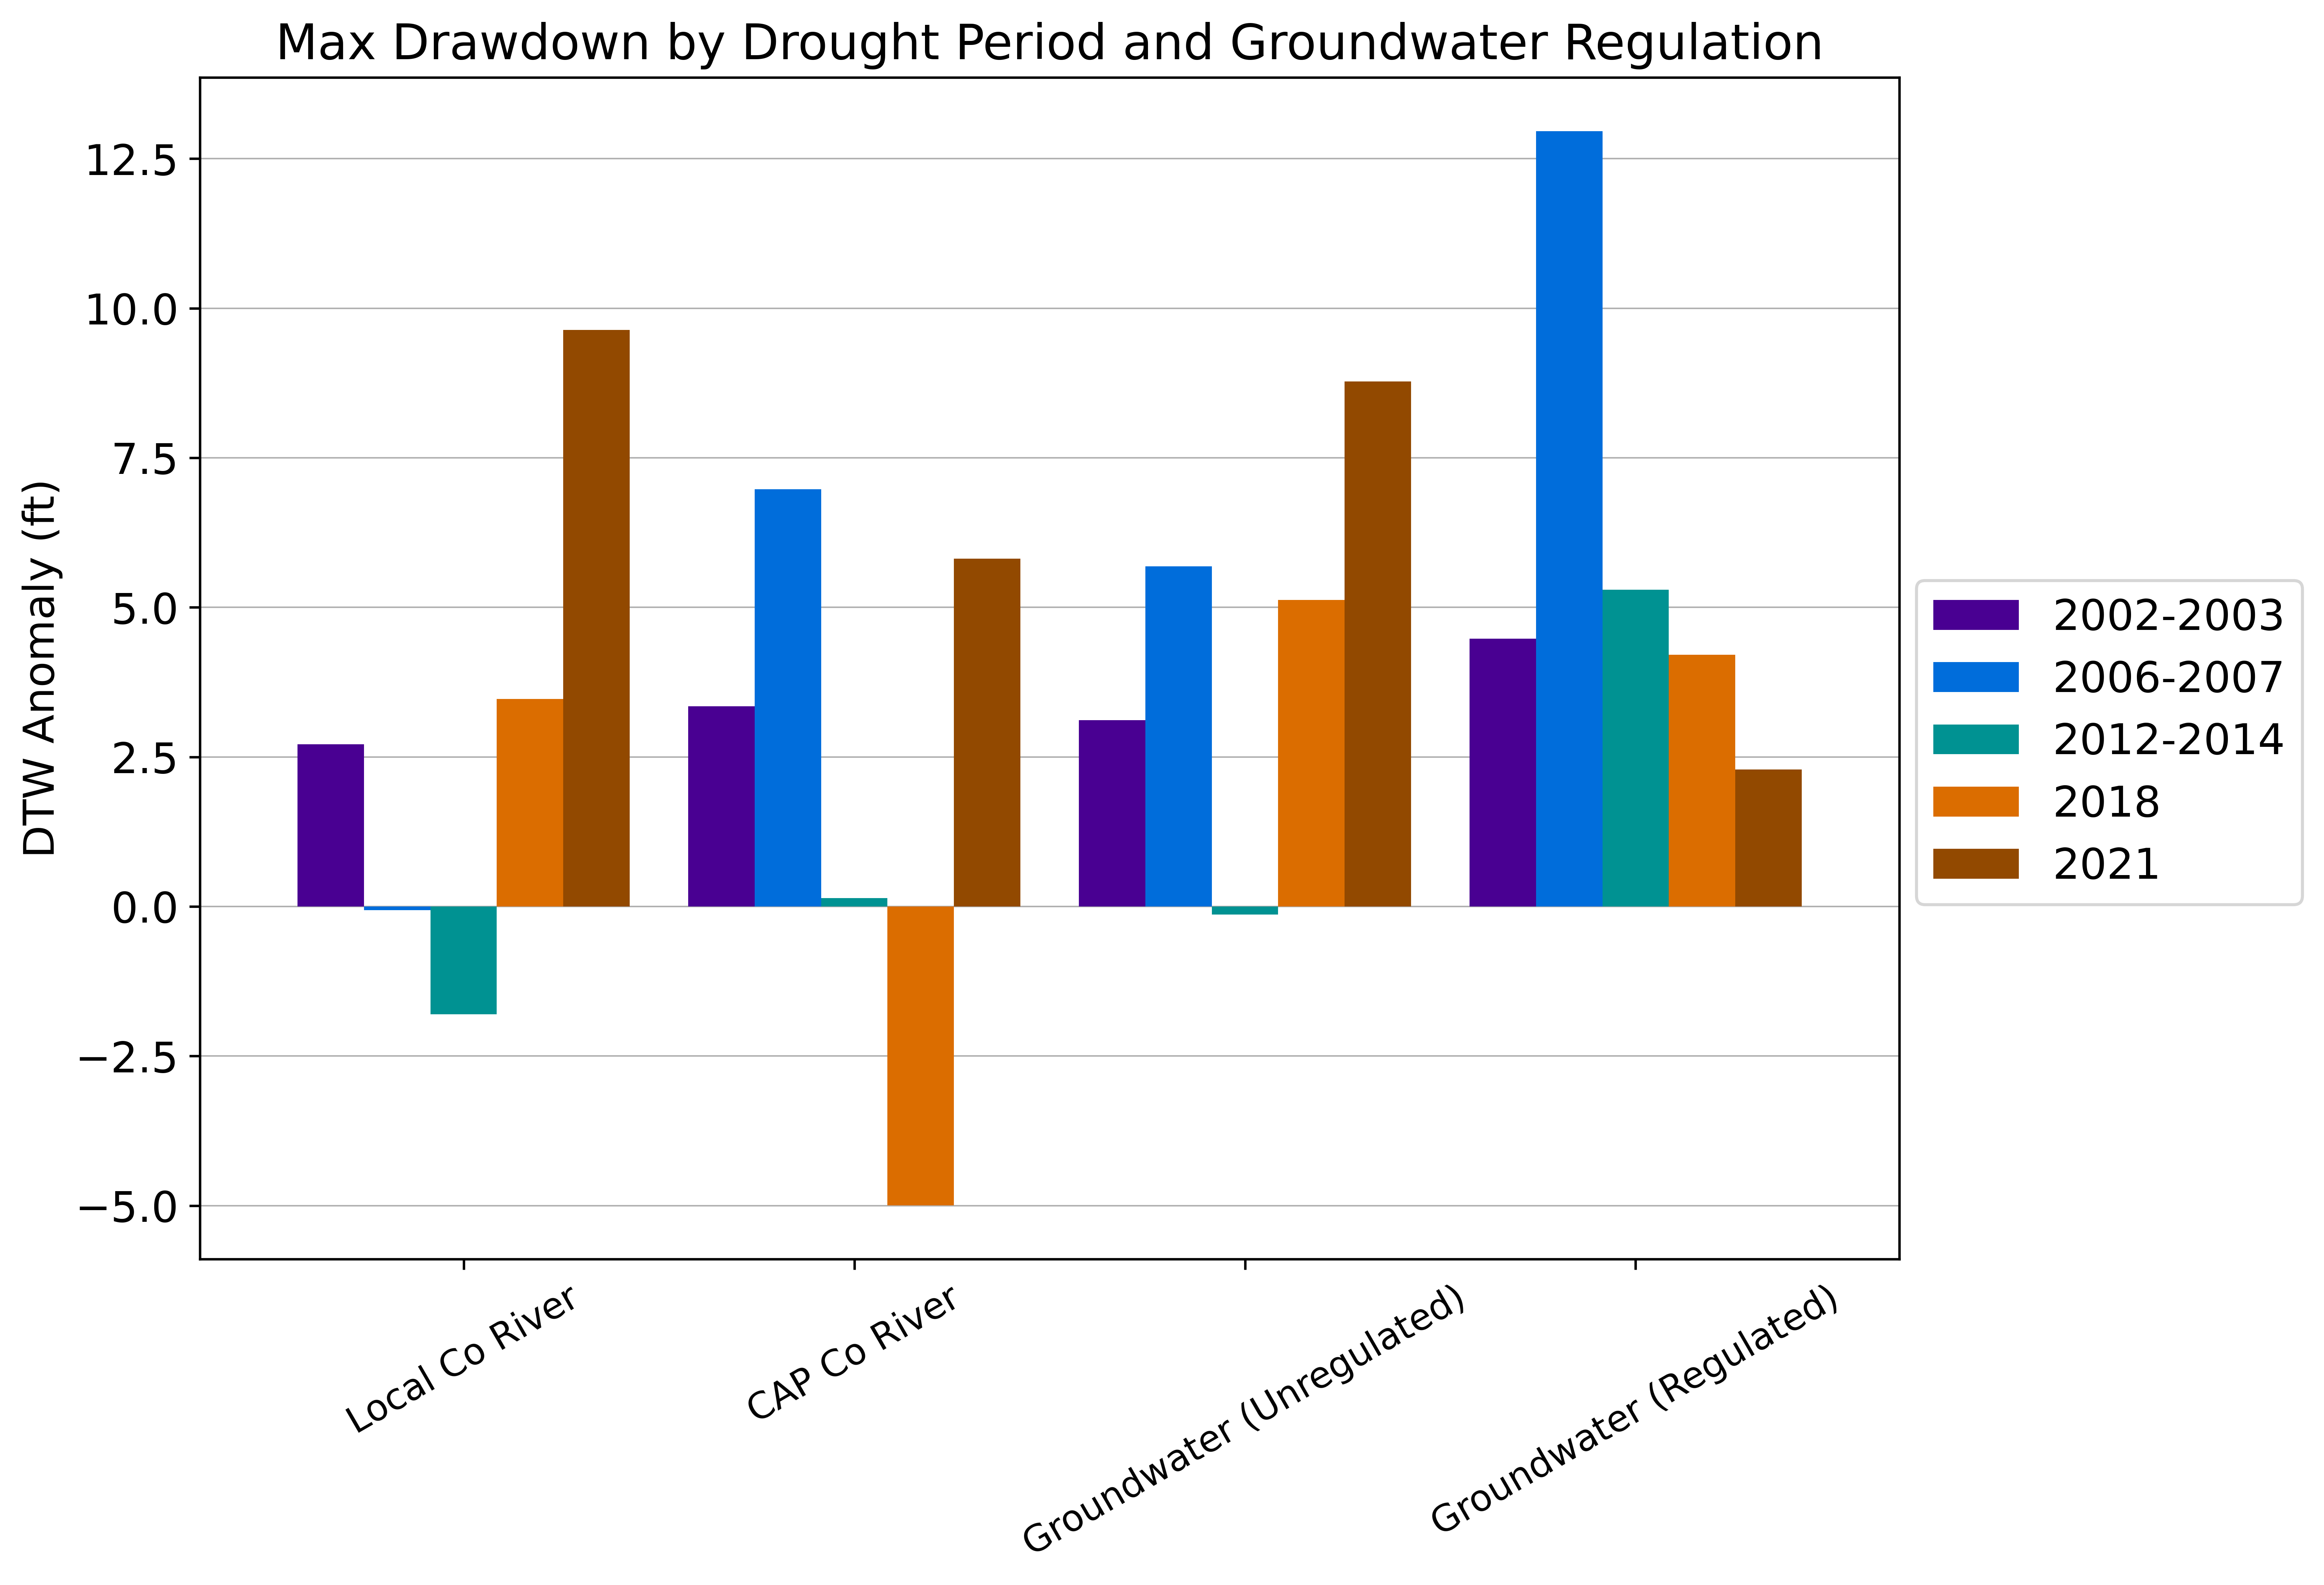

In [57]:
#%% Grouped Bar chart for drawdown (ft)
# name = 'Average DTW Anomalies by Drought Period and Groundwater Regulation'
name = 'Max Drawdown by Drought Period and Groundwater Regulation'

yearlabels = [
        #       "1989-1990"
        #       ,'1996',
              '2002-2003','2006-2007','2012-2014','2018','2021'
              ,'Normal/Wet Years'
        ]
dtw_max_anomalies.index = yearlabels
dtw_max_anomalies = dtw_max_anomalies.transpose()

dtw_max_anomalies.index = betterlabels
del dtw_max_anomalies['Normal/Wet Years']
dtw_max_anomalies

group_colors = [cblind[5],cblind[6],cblind[2]
                ,cblind[12],cblind[11],cblind[10]
                ]

vertlabel = 'DTW Anomaly (ft)'
fsize = 14

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = group_colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )
plt.title(name, fontsize = (fsize+2))
# plt.ylim([10,-2])
plt.ylabel(vertlabel, fontsize = fsize)
plt.xticks(rotation=30, fontsize = fsize-2)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
# plt.set_dpi(600)

# plt.savefig(figurepath+name+'_groupedchart', bbox_inches = 'tight')
# plt.savefig(outputpath+name+'_anomalies_SWAccess_groupedchart', bbox_inches = 'tight')

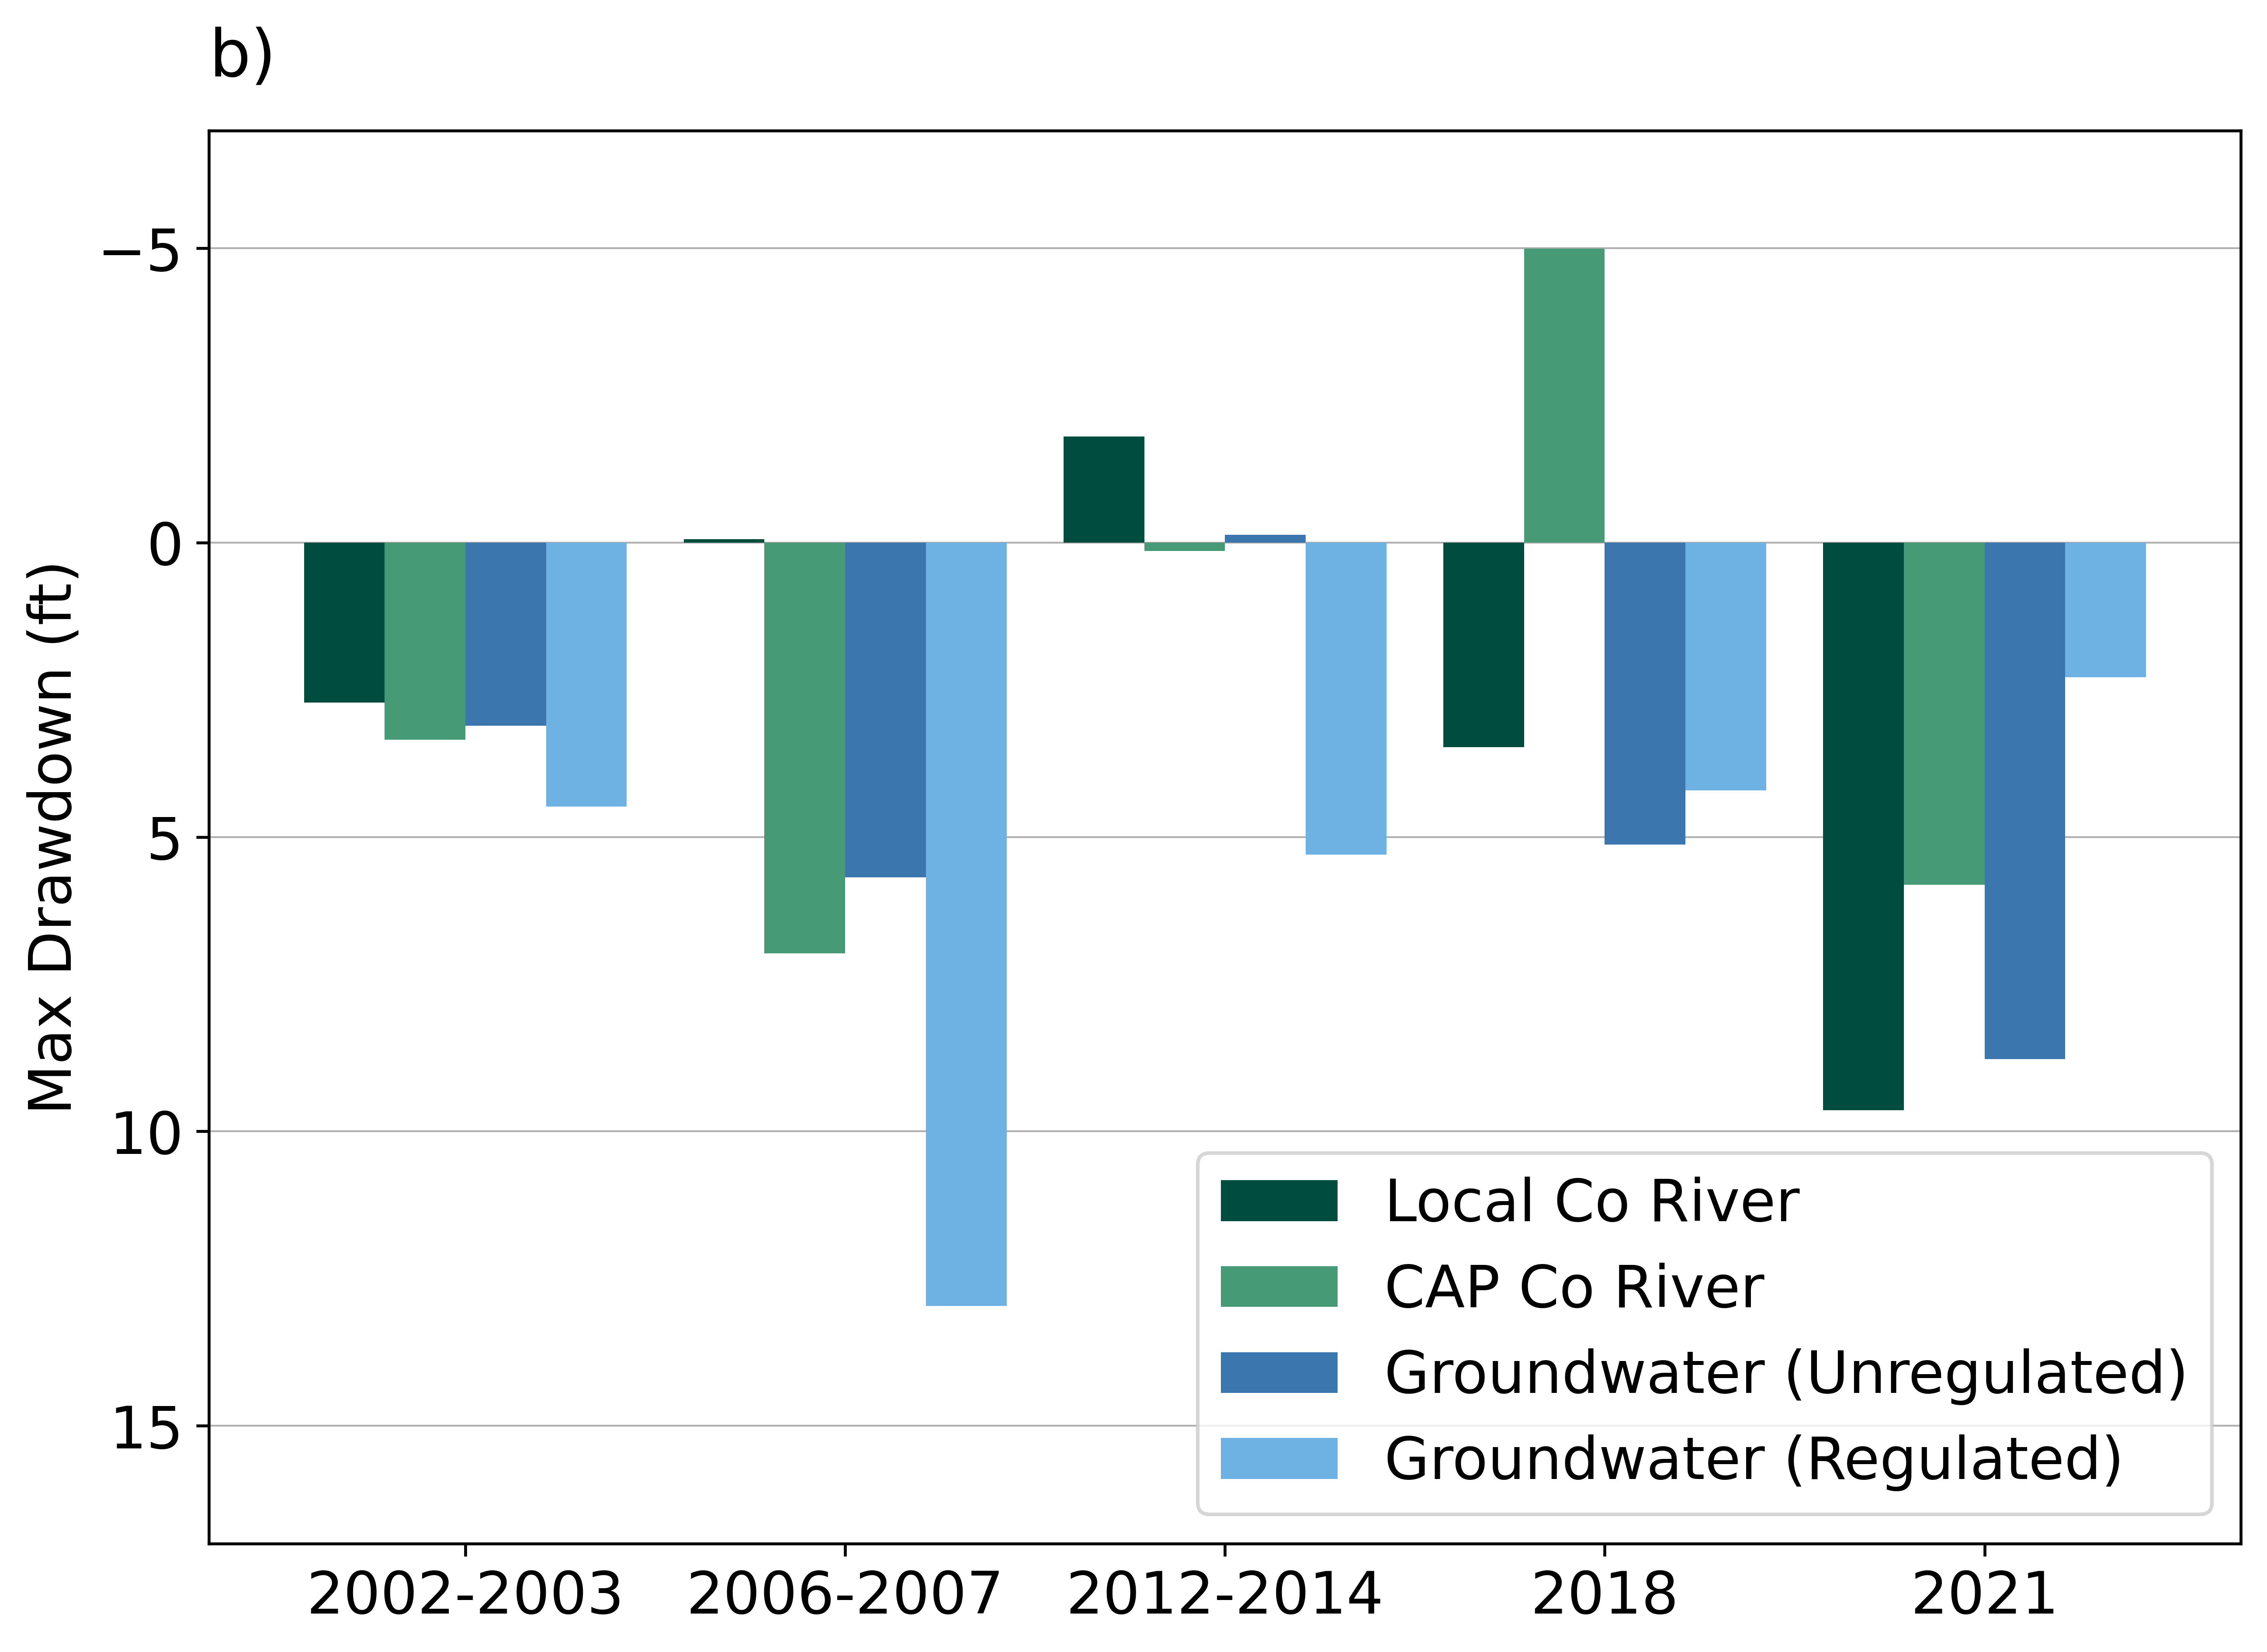

In [58]:
#%% Grouped Bar chart for drawdown (ft)
name = 'Max Drawdown by Drought Period and Access to Surface Water'

dtw_max_anomalies = dtw_max_anomalies.transpose()

vertlabel = 'Max Drawdown (ft)'
fsize = 16
well_ylimit = 10

plt.rcParams["figure.dpi"] = 600
dtw_max_anomalies.plot(figsize = (10,7),
        kind='bar',
        stacked=False,
        # title=name,
        color = colors,
        zorder = 2,
        width = 0.85,
        fontsize = fsize
        )

# plt.title(name, fontsize = (fsize+2))
plt.title('b)', fontsize = fsize+2, loc='left',pad=15)
plt.ylim([17,-7])
plt.ylabel(vertlabel, fontsize = fsize)
# plt.xlabel("Severe Drought Period", fontsize =fsize)
plt.xticks(rotation=0, fontsize = fsize)
plt.grid(axis='y', linewidth=0.5, zorder=0)
plt.legend(loc=[1.01,0.3],fontsize = fsize)
plt.legend(loc='lower right',fontsize = fsize)
# plt.set_dpi(600)
plt.savefig(figurepath + '/Figure6b', bbox_inches='tight')

In [27]:
print("Done-zo!")

Done-zo!
